# Fetch dataset, engineer features

In [ ]:
# ============================================
# SOLARINDS Feature Engineering with Volatility Regimes
# ============================================

import yfinance as yf
import pandas as pd
import numpy as np

# --------------------------------------------
# 1. Download SOLARINDS stock data
# --------------------------------------------
ticker = "SOLARINDS.NS"
data = yf.download(ticker, start="2010-01-01", end="2025-10-31")

# Flatten MultiIndex columns (for consistency)
data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns.values]

# --------------------------------------------
# 2. Daily percentage returns
# --------------------------------------------
data['Return'] = data['Close_SOLARINDS.NS'].pct_change() * 100

# --------------------------------------------
# 3. Lag features (1 to 5 days)
# --------------------------------------------
for lag in range(1, 6):
    data[f'Lag{lag}'] = data['Return'].shift(lag)

# --------------------------------------------
# 4. Volume (in billions)
# --------------------------------------------
data['Volume'] = data['Volume_SOLARINDS.NS'] / 1e9

# --------------------------------------------
# 5. RSI (14-day) and 3-day average RSI (using data up to t-1)
# --------------------------------------------
window_length = 14
delta = data['Close_SOLARINDS.NS'].diff()

gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(window=window_length, min_periods=window_length).mean()
avg_loss = loss.rolling(window=window_length, min_periods=window_length).mean()

rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

# Shift RSI forward by one day so RSI_t uses data up to t-1
data['RSI'] = rsi.shift(1)
data['RSI_Avg3'] = data['RSI'].rolling(window=3).mean()

# --------------------------------------------
# 6. EMA features (20-day) — computed using data up to t-1
# --------------------------------------------
ema_period = 20
data['EMA_raw'] = data['Close_SOLARINDS.NS'].ewm(span=ema_period, adjust=False).mean()

# Shift EMA so that EMA_t only uses prices up to t-1
data['EMA'] = data['EMA_raw'].shift(1)

# Derived EMA-based features (compare t's close with EMA_{t-1})
data['EMA_Compare'] = np.where(
    data['Close_SOLARINDS.NS'] > data['EMA'],
    'Above EMA',
    'Below EMA'
)

data['EMA_Diff_Pct'] = ((data['Close_SOLARINDS.NS'] - data['EMA']) / data['EMA']) * 100

# --------------------------------------------
# 7. Weighted lag average (decaying weights)
# --------------------------------------------
weights = np.array([0.5**(i-1) for i in range(1, 6)])
weights = weights / weights.sum()
lag_cols = [f'Lag{i}' for i in range(1, 6)]
data['Lag_Weighted_Avg'] = data[lag_cols].mul(weights, axis=1).sum(axis=1)

# --------------------------------------------
# 8. Today's return and Direction classification
# --------------------------------------------
data['Today'] = data['Return']

up_thresh = 1
down_thresh = -1

def classify_direction(x, up_thresh=up_thresh, down_thresh=down_thresh):
    if x > up_thresh:
        return 'UP'
    elif x < down_thresh:
        return 'DOWN'
    else:
        return 'HOLD'

data['Direction'] = data['Today'].apply(classify_direction)

# --------------------------------------------
# 9. Add Year
# --------------------------------------------
data['Date'] = data.index
data['Year'] = data.index.year

# --------------------------------------------
# 10. Add India VIX and define volatility regimes
# --------------------------------------------
vix = yf.download("^INDIAVIX", start="2010-01-01", end="2025-10-31")['Open']
vix.name = '^INDIAVIX'
data = data.merge(vix, left_index=True, right_index=True, how='left')

low_thresh = data['^INDIAVIX'].quantile(0.30)
high_thresh = data['^INDIAVIX'].quantile(0.70)

def classify_volatility(v):
    if v < low_thresh:
        return 'Low'
    elif v > high_thresh:
        return 'High'
    else:
        return 'Medium'

data['Volatility_Regime'] = data['^INDIAVIX'].apply(classify_volatility)

# --------------------------------------------
# 11. Define final feature set (without VIX or Regime)
# --------------------------------------------
feature_cols = [ 'Date',
    'Close_SOLARINDS.NS',
    'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5',
    'Lag_Weighted_Avg',
    'Volume',
    'RSI', 'RSI_Avg3',
    'EMA', 'EMA_Compare', 'EMA_Diff_Pct',
    'Year',
    'Direction'  # target variable
]

final_cols_with_vix = feature_cols + ['^INDIAVIX', 'Volatility_Regime']

# --------------------------------------------
# 12. Create final_df with volatility classification
# --------------------------------------------
final_df = data[final_cols_with_vix].dropna().reset_index(drop=True)

# Split by regime (but drop regime & VIX from each subset)
low_vol_df = final_df[final_df['Volatility_Regime'] == 'Low'][feature_cols].reset_index(drop=True)
med_vol_df = final_df[final_df['Volatility_Regime'] == 'Medium'][feature_cols].reset_index(drop=True)
high_vol_df = final_df[final_df['Volatility_Regime'] == 'High'][feature_cols].reset_index(drop=True)

# --------------------------------------------
# 13. Save and summarize
# --------------------------------------------
final_df.to_csv("SOLARINDS_Features_with_VIX.csv", index=False)
low_vol_df.to_csv("SOLARINDS_LowVol.csv", index=False)
med_vol_df.to_csv("SOLARINDS_MedVol.csv", index=False)
high_vol_df.to_csv("SOLARINDS_HighVol.csv", index=False)

print("✅ Feature engineering complete.")
print(f"Low Vol Days: {len(low_vol_df)} | Medium Vol Days: {len(med_vol_df)} | High Vol Days: {len(high_vol_df)}")
print("\nNote: Regime-wise datasets exclude both '^INDIAVIX' and 'Volatility_Regime' columns.")


/tmp/ipython-input-2857150127.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2010-01-01", end="2025-10-31")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2857150127.py:106: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^INDIAVIX", start="2010-01-01", end="2025-10-31")['Open']
[*********************100%***********************]  1 of 1 completed


✅ Feature engineering complete.
Low Vol Days: 1166 | Medium Vol Days: 1555 | High Vol Days: 1149

Note: Regime-wise datasets exclude both '^INDIAVIX' and 'Volatility_Regime' columns.


## Data in tabular form

In [ ]:
final_df['Direction'].value_counts() #find count of each class in direction

#clearly, hold has significantly more datapoints than the other two classes

,count
Direction,
HOLD,2097
UP,928
DOWN,845


In [ ]:
final_df.head()

,Date,Close_SOLARINDS.NS,Lag1,Lag2,Lag3,Lag4,Lag5,Lag_Weighted_Avg,Volume,RSI,RSI_Avg3,EMA,EMA_Compare,EMA_Diff_Pct,Year,Direction,^INDIAVIX,Volatility_Regime
0,2010-01-28,75.416298,-2.031917,-3.128298,4.314381,-4.749748,-0.716583,-1.628890,0.000046,47.551642,51.405888,75.471925,Below EMA,-0.073706,2010,UP,27.570000,High
1,2010-01-29,75.748512,3.703666,-2.031917,-3.128298,4.314381,-4.749748,1.108682,0.000181,53.229872,50.796769,75.466627,Above EMA,0.373523,2010,HOLD,28.590000,High
2,2010-02-01,75.990921,0.440507,3.703666,-2.031917,-3.128298,4.314381,0.858309,0.000002,56.312849,52.364787,75.493474,Above EMA,0.658928,2010,HOLD,26.799999,High
3,2010-02-02,76.206390,0.320018,0.440507,3.703666,-2.031917,-3.128298,0.524738,0.000004,54.622797,54.721839,75.540849,Above EMA,0.881034,2010,HOLD,24.780001,High
4,2010-02-03,76.565498,0.283546,0.320018,0.440507,3.703666,-2.031917,0.459172,0.000020,52.063752,54.333133,75.604234,Above EMA,1.271442,2010,HOLD,26.059999,High


# 1. Basic Softmax model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix



In [ ]:
# Encode categorical variables

df = final_df.copy()
label_encoders = {}
for col in ['EMA_Compare', 'Volatility_Regime', 'Direction']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [ ]:
X = df.drop(columns=['Direction', 'Volatility_Regime', 'Close_SOLARINDS.NS', 'Date'])
y = df['Direction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=17)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#resamples data to remove imbalance of datapoints per class as observed earlier

print("original data: ", '\n', y_train.value_counts(), '\n')

print("resampled data: ", '\n', y_resampled.value_counts())

original data:  
 Direction
1    1678
2     742
0     676
Name: count, dtype: int64 

resampled data:  
 Direction
1    1678
2    1678
0    1678
Name: count, dtype: int64


In [ ]:
softmax_model = LogisticRegression(solver='lbfgs', penalty='l2', C=0.5, max_iter=1000)

softmax_model.fit(X_resampled, y_resampled)

LogisticRegression(C=0.5, max_iter=1000)

In [ ]:
y_pred = softmax_model.predict(X_test)

In [ ]:
print("Model Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoders['Direction'].classes_))

# confusion matrix:
# rows = true class
# columns = predicted class
# Cij = no of datapoints of class i predicted as class j

Model Evaluation:
[[130  32   7]
 [102 240  77]
 [  4  38 144]]
              precision    recall  f1-score   support

        DOWN       0.55      0.77      0.64       169
        HOLD       0.77      0.57      0.66       419
          UP       0.63      0.77      0.70       186

    accuracy                           0.66       774
   macro avg       0.65      0.71      0.67       774
weighted avg       0.69      0.66      0.66       774



# 2. Separate models for high, medium and low market volatility

## High Volatility

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# --- Step 1: Copy original dataframe ---
hdf = high_vol_df.copy()

# --- Step 2: Ensure Date column is datetime ---
hdf['Date'] = pd.to_datetime(hdf['Date'])

# --- Step 3: Encode categorical columns ---
label_encoders = {}
for col in ['EMA_Compare', 'Direction']:
    le = LabelEncoder()
    hdf[col] = le.fit_transform(hdf[col])
    label_encoders[col] = le

# --- Step 4: Split into train (2010–2019) and test (2020–2025) ---
train_df = hdf[hdf['Date'].dt.year <= 2019].copy()
test_df  = hdf[hdf['Date'].dt.year >= 2020].copy()

# --- Step 5: Separate features and target ---
X_train = train_df.drop(columns=['Direction', 'Close_SOLARINDS.NS'])
y_train = train_df['Direction']
X_test  = test_df.drop(columns=['Direction', 'Close_SOLARINDS.NS'])
y_test  = test_df['Direction']

# --- Step 6: Scale numeric features (fit on train, transform on test) ---
scaler = StandardScaler()
X_train_features = X_train.drop(columns=['Date', 'Year'], errors='ignore')
X_test_features  = X_test.drop(columns=['Date', 'Year'], errors='ignore')
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled  = scaler.transform(X_test_features)

# --- Step 7: Handle imbalance using SMOTE ---
smote = SMOTE(random_state=17)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# --- Step 8: Train softmax logistic regression ---
softmax_model = LogisticRegression(solver='lbfgs', penalty='l2', C=0.5, max_iter=1000)
softmax_model.fit(X_resampled, y_resampled)

# --- Feature Importance (Coefficient Display) ---
# Use feature names from X_train_features for display
importance_df = pd.DataFrame({
    'Feature': X_train_features.columns,
    'Coefficient': softmax_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\nFeature importances (coefficients):")
print(importance_df)

# --- Step 9: Predictions & probability scores ---
y_pred = softmax_model.predict(X_test_scaled)
y_proba = softmax_model.predict_proba(X_test_scaled)

# --- Step 10: Build probability dataframe ---
proba_df_high = pd.DataFrame(
    y_proba,
    columns=[f"P_{cls}" for cls in softmax_model.classes_]
)
proba_df_high["Predicted"] = y_pred
proba_df_high["Confidence"] = proba_df_high[[f"P_{cls}" for cls in softmax_model.classes_]].max(axis=1)

# Add back corresponding Date and Close price for backtesting
proba_df_high["Date"] = test_df["Date"].values
proba_df_high["Close_SOLARINDS.NS"] = test_df["Close_SOLARINDS.NS"].values

# --- Step 11: Save or preview ---
proba_df_high.to_csv("probability_scores_high.csv", index=False)
print("\nProbability scores (first 10 samples):")
print(proba_df_high.head(10))

# --- Step 12: Evaluation ---
print("\nModel Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoders['Direction'].classes_))




Feature importances (coefficients):
             Feature  Coefficient
8           RSI_Avg3     1.712992
5   Lag_Weighted_Avg     0.949646
0               Lag1     0.635319
3               Lag4     0.571628
2               Lag3     0.559055
4               Lag5     0.475628
10       EMA_Compare     0.467750
1               Lag2     0.405055
7                RSI     0.166844
6             Volume    -0.029813
9                EMA    -0.216796
11      EMA_Diff_Pct    -3.641305

Probability scores (first 10 samples):
        P_0       P_1           P_2  Predicted  Confidence       Date  \
0  0.057160  0.611346  3.314935e-01          1    0.611346 2020-03-02   
1  0.077287  0.290879  6.318349e-01          2    0.631835 2020-03-03   
2  0.212261  0.588369  1.993703e-01          1    0.588369 2020-03-04   
3  0.035012  0.492571  4.724172e-01          1    0.492571 2020-03-05   
4  0.449297  0.498428  5.227491e-02          1    0.498428 2020-03-06   
5  0.781256  0.212834  5.910301e-03        

## Medium Volatility

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# --- Step 1: Copy original dataframe ---
mdf = med_vol_df.copy()

# --- Step 2: Ensure Date column is datetime ---
mdf['Date'] = pd.to_datetime(mdf['Date'])

# --- Step 3: Encode categorical columns ---
label_encoders = {}
for col in ['EMA_Compare', 'Direction']:
    le = LabelEncoder()
    mdf[col] = le.fit_transform(mdf[col])
    label_encoders[col] = le

# --- Step 4: Split into train (2010–2019) and test (2020–2025) ---
train_df = mdf[mdf['Date'].dt.year <= 2019].copy()
test_df  = mdf[mdf['Date'].dt.year >= 2020].copy()

# --- Step 5: Separate features and target ---
X_train = train_df.drop(columns=['Direction', 'Close_SOLARINDS.NS'])
y_train = train_df['Direction']
X_test  = test_df.drop(columns=['Direction', 'Close_SOLARINDS.NS'])
y_test  = test_df['Direction']

# --- Step 6: Scale numeric features (fit on train, transform on test) ---
scaler = StandardScaler()
X_train_features = X_train.drop(columns=['Date', 'Year'], errors='ignore')
X_test_features  = X_test.drop(columns=['Date', 'Year'], errors='ignore')
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled  = scaler.transform(X_test_features)

# --- Step 7: Handle imbalance using SMOTE ---
smote = SMOTE(random_state=17)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# --- Step 8: Train softmax logistic regression ---
softmax_model = LogisticRegression(solver='lbfgs', penalty='l2', C=0.5, max_iter=1000)
softmax_model.fit(X_resampled, y_resampled)

# --- Feature Importance (Coefficient Display) ---
# Use feature names from X_train_features for display
importance_df = pd.DataFrame({
    'Feature': X_train_features.columns,
    'Coefficient': softmax_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\nFeature importances (coefficients):")
print(importance_df)

# --- Step 9: Predictions & probability scores ---
y_pred = softmax_model.predict(X_test_scaled)
y_proba = softmax_model.predict_proba(X_test_scaled)

# --- Step 10: Build probability dataframe ---
proba_df_med = pd.DataFrame(
    y_proba,
    columns=[f"P_{cls}" for cls in softmax_model.classes_]
)
proba_df_med["Predicted"] = y_pred
proba_df_med["Confidence"] = proba_df_med[[f"P_{cls}" for cls in softmax_model.classes_]].max(axis=1)

# Add back corresponding Date and Close price for backtesting
proba_df_med["Date"] = test_df["Date"].values
proba_df_med["Close_SOLARINDS.NS"] = test_df["Close_SOLARINDS.NS"].values

# --- Step 11: Save or preview ---
proba_df_med.to_csv("probability_scores_med.csv", index=False)
print("\nProbability scores (first 10 samples):")
print(proba_df_med.head(10))

# --- Step 12: Evaluation ---
print("\nModel Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoders['Direction'].classes_))




Feature importances (coefficients):
             Feature  Coefficient
8           RSI_Avg3     1.577920
5   Lag_Weighted_Avg     0.922041
1               Lag2     0.608133
0               Lag1     0.564803
2               Lag3     0.507122
10       EMA_Compare     0.461434
3               Lag4     0.425299
7                RSI     0.422333
4               Lag5     0.344669
9                EMA     0.074706
6             Volume    -0.050400
11      EMA_Diff_Pct    -4.022673

Probability scores (first 10 samples):
        P_0       P_1       P_2  Predicted  Confidence       Date  \
0  0.840056  0.156285  0.003659          0    0.840056 2020-01-07   
1  0.753697  0.234266  0.012037          0    0.753697 2020-01-08   
2  0.332413  0.569337  0.098250          1    0.569337 2020-01-09   
3  0.271537  0.634296  0.094168          1    0.634296 2020-01-21   
4  0.582086  0.397075  0.020839          0    0.582086 2020-01-22   
5  0.659553  0.319527  0.020920          0    0.659553 2020-01-23  

## Low Volatility

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# --- Step 1: Copy original dataframe ---
ldf = low_vol_df.copy()

# --- Step 2: Ensure Date column is datetime ---
ldf['Date'] = pd.to_datetime(ldf['Date'])

# --- Step 3: Encode categorical columns ---
label_encoders = {}
for col in ['EMA_Compare', 'Direction']:
    le = LabelEncoder()
    ldf[col] = le.fit_transform(ldf[col])
    label_encoders[col] = le

# --- Step 4: Split into train (2010–2019) and test (2020–2025) ---
train_df = ldf[ldf['Date'].dt.year <= 2019].copy()
test_df  = ldf[ldf['Date'].dt.year >= 2020].copy()

# --- Step 5: Separate features and target ---
X_train = train_df.drop(columns=['Direction', 'Close_SOLARINDS.NS'])
y_train = train_df['Direction']
X_test  = test_df.drop(columns=['Direction', 'Close_SOLARINDS.NS'])
y_test  = test_df['Direction']

# --- Step 6: Scale numeric features (fit on train, transform on test) ---
scaler = StandardScaler()
X_train_features = X_train.drop(columns=['Date', 'Year'], errors='ignore')
X_test_features  = X_test.drop(columns=['Date', 'Year'], errors='ignore')
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled  = scaler.transform(X_test_features)

# --- Step 7: Handle imbalance using SMOTE ---
smote = SMOTE(random_state=17)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# --- Step 8: Train softmax logistic regression ---
softmax_model = LogisticRegression(solver='lbfgs', penalty='l2', C=0.5, max_iter=1000)
softmax_model.fit(X_resampled, y_resampled)

# --- Feature Importance (Coefficient Display) ---
# Use feature names from X_train_features for display
importance_df = pd.DataFrame({
    'Feature': X_train_features.columns,
    'Coefficient': softmax_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\nFeature importances (coefficients):")
print(importance_df)

# --- Step 9: Predictions & probability scores ---
y_pred = softmax_model.predict(X_test_scaled)
y_proba = softmax_model.predict_proba(X_test_scaled)

# --- Step 10: Build probability dataframe ---
proba_df_low = pd.DataFrame(
    y_proba,
    columns=[f"P_{cls}" for cls in softmax_model.classes_]
)
proba_df_low["Predicted"] = y_pred
proba_df_low["Confidence"] = proba_df_low[[f"P_{cls}" for cls in softmax_model.classes_]].max(axis=1)

# Add back corresponding Date and Close price for backtesting
proba_df_low["Date"] = test_df["Date"].values
proba_df_low["Close_SOLARINDS.NS"] = test_df["Close_SOLARINDS.NS"].values

# --- Step 11: Save or preview ---
proba_df_low.to_csv("probability_scores_low.csv", index=False)
print("\nProbability scores (first 10 samples):")
print(proba_df_low.head(10))

# --- Step 12: Evaluation ---
print("\nModel Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoders['Direction'].classes_))



Feature importances (coefficients):
             Feature  Coefficient
8           RSI_Avg3     1.557316
5   Lag_Weighted_Avg     0.888688
1               Lag2     0.761340
3               Lag4     0.485762
4               Lag5     0.470908
0               Lag1     0.457671
7                RSI     0.402753
2               Lag3     0.396377
10       EMA_Compare     0.276289
9                EMA     0.007682
6             Volume    -0.076978
11      EMA_Diff_Pct    -3.541403

Probability scores (first 10 samples):
        P_0       P_1       P_2  Predicted  Confidence       Date  \
0  0.033748  0.341400  0.624852          2    0.624852 2020-01-02   
1  0.098264  0.390683  0.511053          2    0.511053 2020-01-03   
2  0.884583  0.110123  0.005294          0    0.884583 2020-01-06   
3  0.686958  0.290754  0.022287          0    0.686958 2020-01-10   
4  0.401624  0.492245  0.106131          1    0.492245 2020-01-13   
5  0.207945  0.585106  0.206949          1    0.585106 2020-01-14  

# Backtesting on softmax regression strategy

In [ ]:
import pandas as pd

# Assuming these three dataframes already exist from your earlier steps:
# proba_df_low, proba_df_med, proba_df_high

# --- Step 1: Add a column to identify the volatility regime ---
proba_df_low["Regime"] = "Low Volatility"
proba_df_med["Regime"] = "Medium Volatility"
proba_df_high["Regime"] = "High Volatility"

# --- Step 2: Combine all three dataframes ---
combined_proba_df = pd.concat([proba_df_low, proba_df_med, proba_df_high], ignore_index=True)

# --- Step 3: Shuffle the order to simulate mixed trading days ---
combined_proba_df = combined_proba_df.sample(frac=1, random_state=42).reset_index(drop=True)

# --- Step 4: Optional — sort by date if you later need chronological order ---
# combined_proba_df = combined_proba_df.sort_values(by="Date").reset_index(drop=True)

# --- Step 5: Preview the result ---
print("\nCombined probability DataFrame (first 10 rows):")
print(combined_proba_df.head(10))

# --- Step 6: Save for backtesting step ---
combined_proba_df.to_csv("combined_probability_scores.csv", index=False)



Combined probability DataFrame (first 10 rows):
        P_0       P_1       P_2  Predicted  Confidence       Date  \
0  0.922431  0.076851  0.000719          0    0.922431 2023-03-09   
1  0.311463  0.606967  0.081571          1    0.606967 2020-12-15   
2  0.693553  0.272655  0.033792          0    0.693553 2025-02-28   
3  0.074343  0.246516  0.679141          2    0.679141 2024-04-25   
4  0.077287  0.290879  0.631835          2    0.631835 2020-03-03   
5  0.000026  0.062764  0.937210          2    0.937210 2021-10-19   
6  0.028651  0.149270  0.822079          2    0.822079 2022-07-20   
7  0.997351  0.002641  0.000008          0    0.997351 2025-08-08   
8  0.264446  0.392157  0.343397          1    0.392157 2021-09-13   
9  0.967033  0.029515  0.003452          0    0.967033 2025-09-18   

   Close_SOLARINDS.NS             Regime  
0         3771.808838     Low Volatility  
1         1076.183594    High Volatility  
2         8705.388672     Low Volatility  
3         8789.8203

In [ ]:
# --------------------------------------------
# Combine probability dataframes and sort by date
# --------------------------------------------
proba_combined_df = pd.concat([proba_df_low, proba_df_med, proba_df_high], ignore_index=True)

# Sort chronologically
proba_combined_df = proba_combined_df.sort_values(by='Date').reset_index(drop=True)

# Display summary
print(f"✅ Combined probability dataframe created. Total records: {len(proba_combined_df)}")
print(proba_combined_df.head())

proba_combined_df.to_csv("combined_probability_scores_sorted.csv", index=False)



✅ Combined probability dataframe created. Total records: 1428
        P_0       P_1       P_2  Predicted  Confidence       Date  \
0  0.033748  0.341400  0.624852          2    0.624852 2020-01-02   
1  0.098264  0.390683  0.511053          2    0.511053 2020-01-03   
2  0.884583  0.110123  0.005294          0    0.884583 2020-01-06   
3  0.840056  0.156285  0.003659          0    0.840056 2020-01-07   
4  0.753697  0.234266  0.012037          0    0.753697 2020-01-08   

   Close_SOLARINDS.NS             Regime  
0         1080.369019     Low Volatility  
1         1101.244751     Low Volatility  
2         1096.665771     Low Volatility  
3         1089.772949  Medium Volatility  
4         1087.114258  Medium Volatility  


In [ ]:
# ============================================================================
# SOFTMAX LOGISTIC REGRESSION BACKTEST WITH REALISTIC TRADING COSTS
# File: softmax_backtest_realistic.py
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta


# ============================================================================
# TRANSACTION COSTS & SLIPPAGE CONFIGURATION
# ============================================================================

class TradingCosts:
    """
    India-specific transaction costs (NSE equity trading)
    Based on typical retail brokerage and regulatory fees as of 2024
    """
    # Brokerage fees
    BROKERAGE_BUY = 0.0003      # 0.03% on buy side
    BROKERAGE_SELL = 0.0003     # 0.03% on sell side

    # Securities Transaction Tax (STT)
    STT_BUY = 0.0                # No STT on buy
    STT_SELL = 0.00025           # 0.025% on sell (equity segment)

    # GST on brokerage (18% in India)
    GST_RATE = 0.18

    # Exchange & clearing charges (combined)
    EXCHANGE_CHARGES = 0.000005   # ~0.0005%
    CLEARING_CHARGES = 0.000005

    @staticmethod
    def calculate_transaction_cost(price, quantity, side='buy'):
        """
        Calculate all-in transaction cost for a trade

        Args:
            price (float): Trade execution price
            quantity (int): Number of shares
            side (str): 'buy' or 'sell'

        Returns:
            float: Total transaction cost in rupees
        """
        trade_value = price * quantity

        # Brokerage
        if side == 'buy':
            brokerage = trade_value * TradingCosts.BROKERAGE_BUY
        else:
            brokerage = trade_value * TradingCosts.BROKERAGE_SELL

        # GST on brokerage
        gst = brokerage * TradingCosts.GST_RATE

        # STT (only on sell)
        stt = trade_value * TradingCosts.STT_SELL if side == 'sell' else 0

        # Exchange & clearing charges
        exchange_clearing = trade_value * (TradingCosts.EXCHANGE_CHARGES + TradingCosts.CLEARING_CHARGES)

        total_cost = brokerage + gst + stt + exchange_clearing
        return total_cost

    @staticmethod
    def calculate_total_round_trip_cost(entry_price, exit_price, quantity):
        """Calculate total cost for a complete buy-sell round trip"""
        buy_cost = TradingCosts.calculate_transaction_cost(entry_price, quantity, side='buy')
        sell_cost = TradingCosts.calculate_transaction_cost(exit_price, quantity, side='sell')
        return buy_cost + sell_cost


class SlippageModel:
    """
    Dynamic slippage model based on market conditions
    Slippage = difference between expected and actual execution price
    """

    def __init__(self, volatility_column='RSI'):
        self.volatility_column = volatility_column

    @staticmethod
    def calculate_slippage(price, volatility_level=50, order_size=1):
        """
        Calculate realistic slippage percentage

        Args:
            price (float): Current price level
            volatility_level (float): Market volatility (0-100 scale, e.g., RSI)
            order_size (int): Number of shares

        Returns:
            float: Slippage percentage (as decimal)
        """
        # Base slippage for liquid stocks
        base_slippage = 0.0005  # 0.05% baseline

        # Volatility-based adjustment
        if volatility_level > 70:
            vol_adjustment = 0.005   # High volatility: +0.5%
        elif volatility_level > 50:
            vol_adjustment = 0.003   # Medium volatility: +0.3%
        else:
            vol_adjustment = 0.0010  # Low volatility: +0.1%

        # Order size impact (larger orders face worse execution)
        # For 1 share: minimal impact; for 100+ shares: noticeable slippage
        if order_size > 50:
            size_adjustment = order_size * 0.00001  # +0.001% per share
        else:
            size_adjustment = 0

        total_slippage = base_slippage + vol_adjustment + size_adjustment
        return total_slippage

    @staticmethod
    def apply_slippage_to_price(price, slippage_pct, side='buy'):
        """
        Apply slippage to execution price

        Args:
            price (float): Ideal execution price
            slippage_pct (float): Slippage percentage (as decimal)
            side (str): 'buy' (gets worse price) or 'sell' (gets worse price)

        Returns:
            float: Actual execution price after slippage
        """
        if side == 'buy':
            # Buy: you get worse (higher) price
            return price * (1 + slippage_pct)
        else:
            # Sell/Short cover: you get worse (lower) price
            return price * (1 - slippage_pct)


# ============================================================================
# MAIN BACKTEST CLASS
# ============================================================================

class RealisticBacktestingSoftmax:
    """
    Advanced backtesting for Softmax Logistic Regression with:
    - Transaction costs (brokerage, STT, GST, exchange charges)
    - Realistic slippage model
    - Stop-loss / Take-profit logic
    - Risk management
    """

    def __init__(self, probability_file_path, confidence_threshold=0.60,
                 stop_loss_pct=0.02, take_profit_pct=0.05,
                 account_capital=100000, risk_per_trade=0.02):
        """
        Initialize realistic backtesting strategy

        Args:
            probability_file_path (str): Path to probability scores CSV
            confidence_threshold (float): Min confidence to trade (0.60 = 60%)
            stop_loss_pct (float): Exit if loss exceeds this pct (default 2%)
            take_profit_pct (float): Exit if gain reaches this pct (default 5%)
            account_capital (float): Total trading capital in rupees
            risk_per_trade (float): Risk per trade as % of capital (default 2%)
        """
        self.df = pd.read_csv(probability_file_path)
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        self.df = self.df.sort_values('Date').reset_index(drop=True)

        self.confidence_threshold = confidence_threshold
        self.stop_loss_pct = stop_loss_pct
        self.take_profit_pct = take_profit_pct
        self.account_capital = account_capital
        self.risk_per_trade = risk_per_trade

        # Calculate position size based on risk management
        self.position_size = self._calculate_position_size()

        # Initialize tracking
        self.cumulative_pnl = 0
        self.cumulative_costs = 0
        self.entry_price = 0
        self.position = 0

        self.results = {
            'Date': [],
            'Close': [],
            'Confidence': [],
            'Predicted': [],
            'Action': [],
            'Entry_Price': [],
            'Exit_Price': [],
            'Position_Size': [],
            'Transaction_Cost': [],
            'Slippage_Cost': [],
            'Daily_PNL_Gross': [],
            'Daily_PNL_Net': [],
            'Cumulative_PNL': [],
            'Total_Costs': []
        }

        print("="*70)
        print("REALISTIC SOFTMAX BACKTEST CONFIGURATION")
        print("="*70)
        print(f"Confidence Threshold: {self.confidence_threshold*100:.0f}%")
        print(f"Stop Loss: {self.stop_loss_pct*100:.1f}%")
        print(f"Take Profit: {self.take_profit_pct*100:.1f}%")
        print(f"Account Capital: ₹{self.account_capital:,.0f}")
        print(f"Risk Per Trade: {self.risk_per_trade*100:.1f}%")
        print(f"Position Size: {self.position_size} shares")
        print("="*70 + "\n")

    def _calculate_position_size(self):
        """Calculate position size based on Kelly Criterion principles"""
        # Risk amount per trade
        risk_amount = self.account_capital * self.risk_per_trade

        # Assume worst-case stop loss distance (2%)
        assumed_entry = 1000
        stop_loss_distance = assumed_entry * self.stop_loss_pct

        # Position size = risk_amount / stop_loss_distance
        position_size = max(1, int(risk_amount / stop_loss_distance))
        return position_size

    def execute_backtest(self):
        """Execute realistic backtest with all costs and risk management"""

        # Day 0: Check for initial signal
        day0_close = self.df.loc[0, 'Close_SOLARINDS.NS']
        day0_confidence = self.df.loc[0, 'Confidence']
        day0_signal = self.df.loc[0, 'Predicted']

        if day0_confidence >= self.confidence_threshold and day0_signal in [0, 2]:
            # Get slippage
            rsi = self.df.loc[0, 'RSI'] if 'RSI' in self.df.columns else 50
            slippage_pct = SlippageModel.calculate_slippage(day0_close, rsi, self.position_size)

            if day0_signal == 2:  # UP - BUY
                # Entry: Buy with slippage
                entry_price_ideal = day0_close
                entry_price_actual = SlippageModel.apply_slippage_to_price(
                    entry_price_ideal, slippage_pct, side='buy'
                )

                # Transaction cost on buy
                txn_cost = TradingCosts.calculate_transaction_cost(
                    entry_price_actual, self.position_size, side='buy'
                )

                # Exit: Settle at next day close
                if len(self.df) > 1:
                    exit_price_ideal = self.df.loc[1, 'Close_SOLARINDS.NS']
                    exit_slippage_pct = SlippageModel.calculate_slippage(
                        exit_price_ideal,
                        self.df.loc[1, 'RSI'] if 'RSI' in self.df.columns else 50,
                        self.position_size
                    )
                    exit_price_actual = SlippageModel.apply_slippage_to_price(
                        exit_price_ideal, exit_slippage_pct, side='sell'
                    )
                else:
                    exit_price_actual = entry_price_actual

                # Transaction cost on sell
                sell_txn_cost = TradingCosts.calculate_transaction_cost(
                    exit_price_actual, self.position_size, side='sell'
                )

                total_txn_cost = txn_cost + sell_txn_cost

                # PNL calculation
                gross_pnl = (exit_price_actual - entry_price_actual) * self.position_size
                net_pnl = gross_pnl - total_txn_cost

                self.cumulative_pnl += net_pnl
                self.cumulative_costs += total_txn_cost

                slippage_cost = (slippage_pct + exit_slippage_pct) * (entry_price_actual * self.position_size)

                action = 'BUY'

                print(f"Day 0: BUY | Entry: ₹{entry_price_actual:.2f}, Exit: ₹{exit_price_actual:.2f}")
                print(f"  Gross PNL: ₹{gross_pnl:.2f}, Net PNL: ₹{net_pnl:.2f}, Costs: ₹{total_txn_cost:.2f}")

            else:  # DOWN - SHORT
                entry_price_ideal = day0_close
                entry_price_actual = SlippageModel.apply_slippage_to_price(
                    entry_price_ideal, slippage_pct, side='sell'
                )

                txn_cost = TradingCosts.calculate_transaction_cost(
                    entry_price_actual, self.position_size, side='sell'
                )

                if len(self.df) > 1:
                    exit_price_ideal = self.df.loc[1, 'Close_SOLARINDS.NS']
                    exit_slippage_pct = SlippageModel.calculate_slippage(
                        exit_price_ideal,
                        self.df.loc[1, 'RSI'] if 'RSI' in self.df.columns else 50,
                        self.position_size
                    )
                    exit_price_actual = SlippageModel.apply_slippage_to_price(
                        exit_price_ideal, exit_slippage_pct, side='buy'
                    )
                else:
                    exit_price_actual = entry_price_actual

                buy_txn_cost = TradingCosts.calculate_transaction_cost(
                    exit_price_actual, self.position_size, side='buy'
                )

                total_txn_cost = txn_cost + buy_txn_cost

                # SHORT: profit = entry - exit
                gross_pnl = (entry_price_actual - exit_price_actual) * self.position_size
                net_pnl = gross_pnl - total_txn_cost

                self.cumulative_pnl += net_pnl
                self.cumulative_costs += total_txn_cost

                slippage_cost = (slippage_pct + exit_slippage_pct) * (entry_price_actual * self.position_size)

                action = 'SHORT'

                print(f"Day 0: SHORT | Entry: ₹{entry_price_actual:.2f}, Exit: ₹{exit_price_actual:.2f}")
                print(f"  Gross PNL: ₹{gross_pnl:.2f}, Net PNL: ₹{net_pnl:.2f}, Costs: ₹{total_txn_cost:.2f}")

        else:
            action = 'NO_TRADE'
            entry_price_actual = None
            exit_price_actual = None
            gross_pnl = 0
            net_pnl = 0
            total_txn_cost = 0
            slippage_cost = 0

        # Record day 0
        self.results['Date'].append(self.df.loc[0, 'Date'])
        self.results['Close'].append(day0_close)
        self.results['Confidence'].append(day0_confidence)
        self.results['Predicted'].append(day0_signal)
        self.results['Action'].append(action)
        self.results['Entry_Price'].append(entry_price_actual)
        self.results['Exit_Price'].append(exit_price_actual)
        self.results['Position_Size'].append(self.position_size if action != 'NO_TRADE' else 0)
        self.results['Transaction_Cost'].append(total_txn_cost)
        self.results['Slippage_Cost'].append(slippage_cost)
        self.results['Daily_PNL_Gross'].append(gross_pnl)
        self.results['Daily_PNL_Net'].append(net_pnl)
        self.results['Cumulative_PNL'].append(self.cumulative_pnl)
        self.results['Total_Costs'].append(self.cumulative_costs)

        # Days 1 onwards
        for i in range(1, len(self.df)):
            current_date = self.df.loc[i, 'Date']
            current_close = self.df.loc[i, 'Close_SOLARINDS.NS']
            current_confidence = self.df.loc[i, 'Confidence']
            signal_class = self.df.loc[i, 'Predicted']
            rsi = self.df.loc[i, 'RSI'] if 'RSI' in self.df.columns else 50

            # Skip low confidence trades
            if current_confidence < self.confidence_threshold or signal_class == 1:  # HOLD
                action = 'NO_TRADE'
                gross_pnl = 0
                net_pnl = 0
                total_txn_cost = 0
                slippage_cost = 0
                entry_price_actual = None
                exit_price_actual = None
            else:
                prev_close = self.df.loc[i-1, 'Close_SOLARINDS.NS']

                if signal_class == 2:  # BUY
                    slippage_pct = SlippageModel.calculate_slippage(prev_close, rsi, self.position_size)
                    entry_actual = SlippageModel.apply_slippage_to_price(prev_close, slippage_pct, side='buy')
                    entry_price_actual = entry_actual

                    buy_txn = TradingCosts.calculate_transaction_cost(entry_actual, self.position_size, side='buy')

                    # Exit at current close with slippage
                    exit_slippage_pct = SlippageModel.calculate_slippage(current_close, rsi, self.position_size)
                    exit_actual = SlippageModel.apply_slippage_to_price(current_close, exit_slippage_pct, side='sell')
                    exit_price_actual = exit_actual

                    sell_txn = TradingCosts.calculate_transaction_cost(exit_actual, self.position_size, side='sell')

                    total_txn_cost = buy_txn + sell_txn
                    slippage_cost = (slippage_pct + exit_slippage_pct) * (entry_actual * self.position_size)

                    # Gross PNL
                    gross_pnl = (exit_actual - entry_actual) * self.position_size

                    # Check stop loss
                    loss_pct = (entry_actual - exit_actual) / entry_actual
                    if loss_pct > self.stop_loss_pct:
                        action = 'BUY_STOP_LOSS'
                        net_pnl = -self.account_capital * self.risk_per_trade - total_txn_cost
                    else:
                        action = 'BUY'
                        net_pnl = gross_pnl - total_txn_cost

                else:  # SHORT
                    slippage_pct = SlippageModel.calculate_slippage(prev_close, rsi, self.position_size)
                    entry_actual = SlippageModel.apply_slippage_to_price(prev_close, slippage_pct, side='sell')
                    entry_price_actual = entry_actual

                    sell_txn = TradingCosts.calculate_transaction_cost(entry_actual, self.position_size, side='sell')

                    exit_slippage_pct = SlippageModel.calculate_slippage(current_close, rsi, self.position_size)
                    exit_actual = SlippageModel.apply_slippage_to_price(current_close, exit_slippage_pct, side='buy')
                    exit_price_actual = exit_actual

                    buy_txn = TradingCosts.calculate_transaction_cost(exit_actual, self.position_size, side='buy')

                    total_txn_cost = sell_txn + buy_txn
                    slippage_cost = (slippage_pct + exit_slippage_pct) * (entry_actual * self.position_size)

                    # SHORT: profit = entry - exit
                    gross_pnl = (entry_actual - exit_actual) * self.position_size

                    # Check stop loss
                    loss_pct = (exit_actual - entry_actual) / entry_actual
                    if loss_pct > self.stop_loss_pct:
                        action = 'SHORT_STOP_LOSS'
                        net_pnl = -self.account_capital * self.risk_per_trade - total_txn_cost
                    else:
                        action = 'SHORT'
                        net_pnl = gross_pnl - total_txn_cost

                self.cumulative_pnl += net_pnl
                self.cumulative_costs += total_txn_cost

            # Record trade
            self.results['Date'].append(current_date)
            self.results['Close'].append(current_close)
            self.results['Confidence'].append(current_confidence)
            self.results['Predicted'].append(signal_class)
            self.results['Action'].append(action)
            self.results['Entry_Price'].append(entry_price_actual)
            self.results['Exit_Price'].append(exit_price_actual)
            self.results['Position_Size'].append(self.position_size if action != 'NO_TRADE' else 0)
            self.results['Transaction_Cost'].append(total_txn_cost)
            self.results['Slippage_Cost'].append(slippage_cost)
            self.results['Daily_PNL_Gross'].append(gross_pnl)
            self.results['Daily_PNL_Net'].append(net_pnl)
            self.results['Cumulative_PNL'].append(self.cumulative_pnl)
            self.results['Total_Costs'].append(self.cumulative_costs)

        return pd.DataFrame(self.results)

    def calculate_metrics(self, results_df):
        """Calculate comprehensive performance metrics"""
        initial_price = self.df.loc[0, 'Close_SOLARINDS.NS']
        final_price = self.df.iloc[-1]['Close_SOLARINDS.NS']
        final_pnl = results_df['Cumulative_PNL'].iloc[-1]
        total_costs = results_df['Total_Costs'].iloc[-1]

        buy_hold_return = ((final_price / initial_price) - 1) * 100
        strategy_return = (final_pnl / self.account_capital) * 100

        # Drawdown
        cumulative_max = results_df['Cumulative_PNL'].cummax()
        drawdown = (results_df['Cumulative_PNL'] - cumulative_max) / (cumulative_max + 1e-10)
        max_drawdown = drawdown.min() * 100

        # Sharpe ratio
        daily_pnl = results_df['Daily_PNL_Net']
        sharpe = (daily_pnl.mean() / daily_pnl.std()) * np.sqrt(252) if daily_pnl.std() != 0 else 0

        # Win rate
        profitable = len(results_df[results_df['Daily_PNL_Net'] > 0])
        total_trades = len(results_df[results_df['Daily_PNL_Net'] != 0])
        win_rate = (profitable / total_trades) * 100 if total_trades > 0 else 0

        metrics = {
            'Initial_Price': initial_price,
            'Final_Price': final_price,
            'Buy_Hold_Return': buy_hold_return,
            'Strategy_Return': strategy_return,
            'Total_PNL': final_pnl,
            'Total_Costs': total_costs,
            'Max_Drawdown': max_drawdown,
            'Sharpe_Ratio': sharpe,
            'Win_Rate': win_rate,
            'Trading_Days': total_trades,
            'Total_Days': len(results_df)
        }

        return metrics

    def print_summary(self, metrics):
        """Print comprehensive performance summary"""
        print("\n" + "="*70)
        print("REALISTIC SOFTMAX BACKTEST RESULTS")
        print("="*70)
        print(f"\nPrice Movement:")
        print(f"  Initial: ₹{metrics['Initial_Price']:.2f}")
        print(f"  Final: ₹{metrics['Final_Price']:.2f}")
        print(f"  Buy & Hold Return: {metrics['Buy_Hold_Return']:.2f}%")
        print(f"\nStrategy Performance:")
        print(f"  Total PNL: ₹{metrics['Total_PNL']:.2f}")
        print(f"  Strategy Return: {metrics['Strategy_Return']:.2f}%")
        print(f"  Total Costs (txn + slippage): ₹{metrics['Total_Costs']:.2f}")
        print(f"\nRisk Metrics:")
        print(f"  Max Drawdown: {metrics['Max_Drawdown']:.2f}%")
        print(f"  Sharpe Ratio: {metrics['Sharpe_Ratio']:.2f}")
        print(f"  Win Rate: {metrics['Win_Rate']:.2f}%")
        print(f"\nTrading Activity:")
        print(f"  Trading Days: {metrics['Trading_Days']} / {metrics['Total_Days']}")
        print("="*70 + "\n")

    def export_results(self, results_df, csv_path='softmax_backtest_realistic.csv'):
        """Export detailed results"""
        results_df.to_csv(csv_path, index=False)
        print(f"Results exported to '{csv_path}'")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    backtest = RealisticBacktestingSoftmax(
        probability_file_path='combined_probability_scores_sorted.csv',
        confidence_threshold=0.60,
        stop_loss_pct=0.02,
        take_profit_pct=0.05,
        account_capital=100000,
        risk_per_trade=0.02
    )

    print("\nExecuting realistic backtest...\n")
    results_df = backtest.execute_backtest()

    metrics = backtest.calculate_metrics(results_df)
    backtest.print_summary(metrics)

    backtest.export_results(results_df)

    print("\nAction Distribution:")
    print(results_df['Action'].value_counts())

    print("\nTrading Days Summary (first 20):")
    trading_days = results_df[results_df['Daily_PNL_Net'] != 0]
    print(trading_days[['Date', 'Action', 'Entry_Price', 'Exit_Price',
                         'Daily_PNL_Gross', 'Transaction_Cost', 'Daily_PNL_Net']].head(20))

    print("\nCost Analysis:")
    print(f"Total Transaction Costs: ₹{results_df['Transaction_Cost'].sum():.2f}")
    print(f"Total Slippage Costs: ₹{results_df['Slippage_Cost'].sum():.2f}")
    print(f"Combined Cost Impact: {(results_df['Transaction_Cost'].sum() + results_df['Slippage_Cost'].sum()) / abs(results_df['Daily_PNL_Gross'].sum()) * 100:.2f}% of gross PNL")


REALISTIC SOFTMAX BACKTEST CONFIGURATION
Confidence Threshold: 60%
Stop Loss: 2.0%
Take Profit: 5.0%
Account Capital: ₹100,000
Risk Per Trade: 2.0%
Position Size: 100 shares


Executing realistic backtest...

Day 0: BUY | Entry: ₹1083.07, Exit: ₹1098.49
  Gross PNL: ₹1542.17, Net PNL: ₹1435.30, Costs: ₹106.87

REALISTIC SOFTMAX BACKTEST RESULTS

Price Movement:
  Initial: ₹1080.37
  Final: ₹13901.00
  Buy & Hold Return: 1186.69%

Strategy Performance:
  Total PNL: ₹5360830.35
  Strategy Return: 5360.83%
  Total Costs (txn + slippage): ₹546116.91

Risk Metrics:
  Max Drawdown: -38.19%
  Sharpe Ratio: 5.32
  Win Rate: 69.64%

Trading Activity:
  Trading Days: 873 / 1428

Results exported to 'softmax_backtest_realistic.csv'

Action Distribution:
Action
NO_TRADE           555
BUY                455
SHORT              385
SHORT_STOP_LOSS     18
BUY_STOP_LOSS       15
Name: count, dtype: int64

Trading Days Summary (first 20):
         Date Action  Entry_Price   Exit_Price  Daily_PNL_Gross  

#XGBoost Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# --- Step 1: Copy dataframe ---
df = final_df.copy()

# --- Step 2: Encode categorical variables ---
label_encoders = {}
for col in ['EMA_Compare', 'Volatility_Regime', 'Direction']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# --- Step 3: Split train/test by date ---
# Ensure 'Date' is datetime
df['Date'] = pd.to_datetime(df['Date'])

train_df = df[df['Date'].dt.year < 2020].copy()   # Train: 2010–2019
test_df  = df[df['Date'].dt.year >= 2020].copy()  # Test: 2020–2025

print(f"Training samples: {len(train_df)} | Testing samples: {len(test_df)}")

# --- Step 4: Feature-target split ---
feature_cols = [col for col in df.columns if col not in ['Direction', 'Volatility_Regime', 'Close_SOLARINDS.NS', 'Date', 'Year']]
X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]
y_train = train_df['Direction']
y_test  = test_df['Direction']

# Keep Date and Close for later (backtest alignment)
dates_test = test_df['Date'].reset_index(drop=True)
close_test = test_df['Close_SOLARINDS.NS'].reset_index(drop=True)

# --- Step 5: Feature scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 6: Define and train XGBoost model ---
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoders['Direction'].classes_),
    eval_metric='mlogloss',
    learning_rate=0.05,
    max_depth=7,
    n_estimators=700,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=17
)

xgb_model.fit(X_train_scaled, y_train)

# --- Step 7: Predictions ---
y_pred = xgb_model.predict(X_test_scaled)
y_proba = xgb_model.predict_proba(X_test_scaled)

# --- Step 8: Construct probability dataframe for backtesting ---
proba_df = pd.DataFrame(
    y_proba,
    columns=[f"P_{cls}" for cls in label_encoders['Direction'].classes_]
)
proba_df["Predicted"] = label_encoders['Direction'].inverse_transform(y_pred)
proba_df["True"] = label_encoders['Direction'].inverse_transform(y_test.values)
proba_df["Confidence"] = proba_df[[f"P_{cls}" for cls in label_encoders['Direction'].classes_]].max(axis=1)
proba_df["Date"] = dates_test
proba_df["Close_SOLARINDS.NS"] = close_test

# --- Step 9: Sort by date ---
proba_df = proba_df.sort_values(by="Date").reset_index(drop=True)

# --- Step 10: Save and preview ---
proba_df.to_csv("XGB_Probability_Scores_Sorted.csv", index=False)

print("✅ Probability DataFrame created and sorted by date.")
print(proba_df.head())

# --- Step 11: Evaluation ---
print("\nModel Evaluation (XGBoost):")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoders['Direction'].classes_))


Training samples: 2442 | Testing samples: 1428
✅ Probability DataFrame created and sorted by date.
     P_DOWN    P_HOLD      P_UP Predicted  True  Confidence       Date  \
0  0.000060  0.477030  0.522911        UP    UP    0.522911 2020-01-02   
1  0.011550  0.319087  0.669363        UP    UP    0.669363 2020-01-03   
2  0.916448  0.069361  0.014191      DOWN  HOLD    0.916448 2020-01-06   
3  0.790312  0.209060  0.000628      DOWN  HOLD    0.790312 2020-01-07   
4  0.150311  0.847147  0.002542      HOLD  HOLD    0.847147 2020-01-08   

   Close_SOLARINDS.NS  
0         1080.369019  
1         1101.244751  
2         1096.665771  
3         1089.772949  
4         1087.114258  

Model Evaluation (XGBoost):
[[178 143  34]
 [ 78 463 144]
 [ 11 125 252]]
              precision    recall  f1-score   support

        DOWN       0.67      0.50      0.57       355
        HOLD       0.63      0.68      0.65       685
          UP       0.59      0.65      0.62       388

    accuracy       

In [ ]:
# ============================================================================
# XGBOOST BACKTEST WITH REALISTIC TRADING COSTS
# File: xgboost_backtest_realistic.py
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta


# ============================================================================
# TRANSACTION COSTS & SLIPPAGE CONFIGURATION
# ============================================================================

class TradingCosts:
    """
    India-specific transaction costs (NSE equity trading)
    Based on typical retail brokerage and regulatory fees as of 2024
    """
    # Brokerage fees
    BROKERAGE_BUY = 0.0003      # 0.03% on buy side
    BROKERAGE_SELL = 0.0003     # 0.03% on sell side

    # Securities Transaction Tax (STT)
    STT_BUY = 0.0                # No STT on buy
    STT_SELL = 0.00025           # 0.025% on sell (equity segment)

    # GST on brokerage (18% in India)
    GST_RATE = 0.18

    # Exchange & clearing charges (combined)
    EXCHANGE_CHARGES = 0.000005   # ~0.0005%
    CLEARING_CHARGES = 0.000005

    @staticmethod
    def calculate_transaction_cost(price, quantity, side='buy'):
        """
        Calculate all-in transaction cost for a trade

        Args:
            price (float): Trade execution price
            quantity (int): Number of shares
            side (str): 'buy' or 'sell'

        Returns:
            float: Total transaction cost in rupees
        """
        trade_value = price * quantity

        # Brokerage
        if side == 'buy':
            brokerage = trade_value * TradingCosts.BROKERAGE_BUY
        else:
            brokerage = trade_value * TradingCosts.BROKERAGE_SELL

        # GST on brokerage
        gst = brokerage * TradingCosts.GST_RATE

        # STT (only on sell)
        stt = trade_value * TradingCosts.STT_SELL if side == 'sell' else 0

        # Exchange & clearing charges
        exchange_clearing = trade_value * (TradingCosts.EXCHANGE_CHARGES + TradingCosts.CLEARING_CHARGES)

        total_cost = brokerage + gst + stt + exchange_clearing
        return total_cost


class SlippageModel:
    """
    Dynamic slippage model based on market conditions
    Slippage = difference between expected and actual execution price
    """

    @staticmethod
    def calculate_slippage(price, volatility_level=50, order_size=1):
        """
        Calculate realistic slippage percentage

        Args:
            price (float): Current price level
            volatility_level (float): Market volatility (0-100 scale)
            order_size (int): Number of shares

        Returns:
            float: Slippage percentage (as decimal)
        """
        # Base slippage for liquid stocks
        base_slippage = 0.0005  # 0.05% baseline

        # Volatility-based adjustment
        if volatility_level > 70:
            vol_adjustment = 0.005   # High volatility: +0.5%
        elif volatility_level > 50:
            vol_adjustment = 0.003   # Medium volatility: +0.3%
        else:
            vol_adjustment = 0.0010  # Low volatility: +0.1%

        # Order size impact
        if order_size > 50:
            size_adjustment = order_size * 0.00001
        else:
            size_adjustment = 0

        total_slippage = base_slippage + vol_adjustment + size_adjustment
        return total_slippage

    @staticmethod
    def apply_slippage_to_price(price, slippage_pct, side='buy'):
        """
        Apply slippage to execution price

        Args:
            price (float): Ideal execution price
            slippage_pct (float): Slippage percentage (as decimal)
            side (str): 'buy' (gets worse price) or 'sell' (gets worse price)

        Returns:
            float: Actual execution price after slippage
        """
        if side == 'buy':
            # Buy: you get worse (higher) price
            return price * (1 + slippage_pct)
        else:
            # Sell/Short cover: you get worse (lower) price
            return price * (1 - slippage_pct)


# ============================================================================
# MAIN BACKTEST CLASS
# ============================================================================

class RealisticBacktestingXGBoost:
    """
    Advanced backtesting for XGBoost model with:
    - Transaction costs (brokerage, STT, GST, exchange charges)
    - Realistic slippage model
    - Stop-loss logic
    - Risk management
    """

    def __init__(self, probability_file_path, confidence_threshold=0.60,
                 stop_loss_pct=0.02, take_profit_pct=0.05,
                 account_capital=100000, risk_per_trade=0.02):
        """
        Initialize realistic backtesting strategy

        Args:
            probability_file_path (str): Path to probability scores CSV
            confidence_threshold (float): Min confidence to trade
            stop_loss_pct (float): Exit if loss exceeds this pct
            take_profit_pct (float): Exit if gain reaches this pct
            account_capital (float): Total trading capital in rupees
            risk_per_trade (float): Risk per trade as % of capital
        """
        self.df = pd.read_csv(probability_file_path)
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        self.df = self.df.sort_values('Date').reset_index(drop=True)

        self.confidence_threshold = confidence_threshold
        self.stop_loss_pct = stop_loss_pct
        self.take_profit_pct = take_profit_pct
        self.account_capital = account_capital
        self.risk_per_trade = risk_per_trade

        # Calculate position size
        self.position_size = self._calculate_position_size()

        # Initialize tracking
        self.cumulative_pnl = 0
        self.cumulative_costs = 0

        self.results = {
            'Date': [],
            'Close': [],
            'Confidence': [],
            'Predicted': [],
            'Action': [],
            'Entry_Price': [],
            'Exit_Price': [],
            'Position_Size': [],
            'Transaction_Cost': [],
            'Slippage_Cost': [],
            'Daily_PNL_Gross': [],
            'Daily_PNL_Net': [],
            'Cumulative_PNL': [],
            'Total_Costs': []
        }

        print("="*70)
        print("REALISTIC XGBOOST BACKTEST CONFIGURATION")
        print("="*70)
        print(f"Confidence Threshold: {self.confidence_threshold*100:.0f}%")
        print(f"Stop Loss: {self.stop_loss_pct*100:.1f}%")
        print(f"Take Profit: {self.take_profit_pct*100:.1f}%")
        print(f"Account Capital: ₹{self.account_capital:,.0f}")
        print(f"Risk Per Trade: {self.risk_per_trade*100:.1f}%")
        print(f"Position Size: {self.position_size} shares")
        print("="*70 + "\n")

    def _calculate_position_size(self):
        """Calculate position size based on risk management"""
        risk_amount = self.account_capital * self.risk_per_trade
        assumed_entry = 1000
        stop_loss_distance = assumed_entry * self.stop_loss_pct
        position_size = max(1, int(risk_amount / stop_loss_distance))
        return position_size

    def execute_backtest(self):
        """Execute realistic backtest with all costs and risk management"""

        # Day 0
        day0_close = self.df.loc[0, 'Close_SOLARINDS.NS']
        day0_confidence = self.df.loc[0, 'Confidence']
        day0_signal = self.df.loc[0, 'Predicted']  # 'UP', 'DOWN', 'HOLD'

        if day0_confidence >= self.confidence_threshold and day0_signal != 'HOLD':
            slippage_pct = SlippageModel.calculate_slippage(day0_close, 50, self.position_size)

            if day0_signal == 'UP':  # BUY
                entry_ideal = day0_close
                entry_actual = SlippageModel.apply_slippage_to_price(entry_ideal, slippage_pct, side='buy')
                txn_cost = TradingCosts.calculate_transaction_cost(entry_actual, self.position_size, side='buy')

                if len(self.df) > 1:
                    exit_ideal = self.df.loc[1, 'Close_SOLARINDS.NS']
                    exit_slippage_pct = SlippageModel.calculate_slippage(exit_ideal, 50, self.position_size)
                    exit_actual = SlippageModel.apply_slippage_to_price(exit_ideal, exit_slippage_pct, side='sell')
                else:
                    exit_actual = entry_actual

                sell_txn = TradingCosts.calculate_transaction_cost(exit_actual, self.position_size, side='sell')
                total_txn_cost = txn_cost + sell_txn

                gross_pnl = (exit_actual - entry_actual) * self.position_size
                net_pnl = gross_pnl - total_txn_cost
                slippage_cost = (slippage_pct + SlippageModel.calculate_slippage(exit_ideal, 50, self.position_size)) * (entry_actual * self.position_size)

                action = 'BUY'
                entry_price_actual = entry_actual
                exit_price_actual = exit_actual

            else:  # DOWN - SHORT
                entry_ideal = day0_close
                entry_actual = SlippageModel.apply_slippage_to_price(entry_ideal, slippage_pct, side='sell')
                txn_cost = TradingCosts.calculate_transaction_cost(entry_actual, self.position_size, side='sell')

                if len(self.df) > 1:
                    exit_ideal = self.df.loc[1, 'Close_SOLARINDS.NS']
                    exit_slippage_pct = SlippageModel.calculate_slippage(exit_ideal, 50, self.position_size)
                    exit_actual = SlippageModel.apply_slippage_to_price(exit_ideal, exit_slippage_pct, side='buy')
                else:
                    exit_actual = entry_actual

                buy_txn = TradingCosts.calculate_transaction_cost(exit_actual, self.position_size, side='buy')
                total_txn_cost = txn_cost + buy_txn

                gross_pnl = (entry_actual - exit_actual) * self.position_size
                net_pnl = gross_pnl - total_txn_cost
                slippage_cost = (slippage_pct + SlippageModel.calculate_slippage(exit_ideal, 50, self.position_size)) * (entry_actual * self.position_size)

                action = 'SHORT'
                entry_price_actual = entry_actual
                exit_price_actual = exit_actual

            self.cumulative_pnl += net_pnl
            self.cumulative_costs += total_txn_cost

        else:
            action = 'NO_TRADE'
            entry_price_actual = None
            exit_price_actual = None
            gross_pnl = 0
            net_pnl = 0
            total_txn_cost = 0
            slippage_cost = 0

        # Record day 0
        self.results['Date'].append(self.df.loc[0, 'Date'])
        self.results['Close'].append(day0_close)
        self.results['Confidence'].append(day0_confidence)
        self.results['Predicted'].append(day0_signal)
        self.results['Action'].append(action)
        self.results['Entry_Price'].append(entry_price_actual)
        self.results['Exit_Price'].append(exit_price_actual)
        self.results['Position_Size'].append(self.position_size if action != 'NO_TRADE' else 0)
        self.results['Transaction_Cost'].append(total_txn_cost)
        self.results['Slippage_Cost'].append(slippage_cost)
        self.results['Daily_PNL_Gross'].append(gross_pnl)
        self.results['Daily_PNL_Net'].append(net_pnl)
        self.results['Cumulative_PNL'].append(self.cumulative_pnl)
        self.results['Total_Costs'].append(self.cumulative_costs)

        # Days 1 onwards
        for i in range(1, len(self.df)):
            current_date = self.df.loc[i, 'Date']
            current_close = self.df.loc[i, 'Close_SOLARINDS.NS']
            current_confidence = self.df.loc[i, 'Confidence']
            signal_class = self.df.loc[i, 'Predicted']  # 'UP', 'DOWN', 'HOLD'

            # Skip low confidence or HOLD
            if current_confidence < self.confidence_threshold or signal_class == 'HOLD':
                action = 'NO_TRADE'
                gross_pnl = 0
                net_pnl = 0
                total_txn_cost = 0
                slippage_cost = 0
                entry_price_actual = None
                exit_price_actual = None
            else:
                prev_close = self.df.loc[i-1, 'Close_SOLARINDS.NS']

                if signal_class == 'UP':  # BUY
                    slippage_pct = SlippageModel.calculate_slippage(prev_close, 50, self.position_size)
                    entry_actual = SlippageModel.apply_slippage_to_price(prev_close, slippage_pct, side='buy')
                    entry_price_actual = entry_actual

                    buy_txn = TradingCosts.calculate_transaction_cost(entry_actual, self.position_size, side='buy')

                    exit_slippage_pct = SlippageModel.calculate_slippage(current_close, 50, self.position_size)
                    exit_actual = SlippageModel.apply_slippage_to_price(current_close, exit_slippage_pct, side='sell')
                    exit_price_actual = exit_actual

                    sell_txn = TradingCosts.calculate_transaction_cost(exit_actual, self.position_size, side='sell')
                    total_txn_cost = buy_txn + sell_txn
                    slippage_cost = (slippage_pct + exit_slippage_pct) * (entry_actual * self.position_size)

                    gross_pnl = (exit_actual - entry_actual) * self.position_size

                    # Check stop loss
                    loss_pct = (entry_actual - exit_actual) / entry_actual
                    if loss_pct > self.stop_loss_pct:
                        action = 'BUY_STOP_LOSS'
                        net_pnl = -self.account_capital * self.risk_per_trade - total_txn_cost
                    else:
                        action = 'BUY'
                        net_pnl = gross_pnl - total_txn_cost

                else:  # DOWN - SHORT
                    slippage_pct = SlippageModel.calculate_slippage(prev_close, 50, self.position_size)
                    entry_actual = SlippageModel.apply_slippage_to_price(prev_close, slippage_pct, side='sell')
                    entry_price_actual = entry_actual

                    sell_txn = TradingCosts.calculate_transaction_cost(entry_actual, self.position_size, side='sell')

                    exit_slippage_pct = SlippageModel.calculate_slippage(current_close, 50, self.position_size)
                    exit_actual = SlippageModel.apply_slippage_to_price(current_close, exit_slippage_pct, side='buy')
                    exit_price_actual = exit_actual

                    buy_txn = TradingCosts.calculate_transaction_cost(exit_actual, self.position_size, side='buy')
                    total_txn_cost = sell_txn + buy_txn
                    slippage_cost = (slippage_pct + exit_slippage_pct) * (entry_actual * self.position_size)

                    gross_pnl = (entry_actual - exit_actual) * self.position_size

                    # Check stop loss
                    loss_pct = (exit_actual - entry_actual) / entry_actual
                    if loss_pct > self.stop_loss_pct:
                        action = 'SHORT_STOP_LOSS'
                        net_pnl = -self.account_capital * self.risk_per_trade - total_txn_cost
                    else:
                        action = 'SHORT'
                        net_pnl = gross_pnl - total_txn_cost

                self.cumulative_pnl += net_pnl
                self.cumulative_costs += total_txn_cost

            # Record
            self.results['Date'].append(current_date)
            self.results['Close'].append(current_close)
            self.results['Confidence'].append(current_confidence)
            self.results['Predicted'].append(signal_class)
            self.results['Action'].append(action)
            self.results['Entry_Price'].append(entry_price_actual)
            self.results['Exit_Price'].append(exit_price_actual)
            self.results['Position_Size'].append(self.position_size if action != 'NO_TRADE' else 0)
            self.results['Transaction_Cost'].append(total_txn_cost)
            self.results['Slippage_Cost'].append(slippage_cost)
            self.results['Daily_PNL_Gross'].append(gross_pnl)
            self.results['Daily_PNL_Net'].append(net_pnl)
            self.results['Cumulative_PNL'].append(self.cumulative_pnl)
            self.results['Total_Costs'].append(self.cumulative_costs)

        return pd.DataFrame(self.results)

    def calculate_metrics(self, results_df):
        """Calculate comprehensive performance metrics"""
        initial_price = self.df.loc[0, 'Close_SOLARINDS.NS']
        final_price = self.df.iloc[-1]['Close_SOLARINDS.NS']
        final_pnl = results_df['Cumulative_PNL'].iloc[-1]
        total_costs = results_df['Total_Costs'].iloc[-1]

        buy_hold_return = ((final_price / initial_price) - 1) * 100
        strategy_return = (final_pnl / self.account_capital) * 100

        cumulative_max = results_df['Cumulative_PNL'].cummax()
        drawdown = (results_df['Cumulative_PNL'] - cumulative_max) / (cumulative_max + 1e-10)
        max_drawdown = drawdown.min() * 100

        daily_pnl = results_df['Daily_PNL_Net']
        sharpe = (daily_pnl.mean() / daily_pnl.std()) * np.sqrt(252) if daily_pnl.std() != 0 else 0

        profitable = len(results_df[results_df['Daily_PNL_Net'] > 0])
        total_trades = len(results_df[results_df['Daily_PNL_Net'] != 0])
        win_rate = (profitable / total_trades) * 100 if total_trades > 0 else 0

        metrics = {
            'Initial_Price': initial_price,
            'Final_Price': final_price,
            'Buy_Hold_Return': buy_hold_return,
            'Strategy_Return': strategy_return,
            'Total_PNL': final_pnl,
            'Total_Costs': total_costs,
            'Max_Drawdown': max_drawdown,
            'Sharpe_Ratio': sharpe,
            'Win_Rate': win_rate,
            'Trading_Days': total_trades,
            'Total_Days': len(results_df)
        }

        return metrics

    def print_summary(self, metrics):
        """Print comprehensive performance summary"""
        print("\n" + "="*70)
        print("REALISTIC XGBOOST BACKTEST RESULTS")
        print("="*70)
        print(f"\nPrice Movement:")
        print(f"  Initial: ₹{metrics['Initial_Price']:.2f}")
        print(f"  Final: ₹{metrics['Final_Price']:.2f}")
        print(f"  Buy & Hold Return: {metrics['Buy_Hold_Return']:.2f}%")
        print(f"\nStrategy Performance:")
        print(f"  Total PNL: ₹{metrics['Total_PNL']:.2f}")
        print(f"  Strategy Return: {metrics['Strategy_Return']:.2f}%")
        print(f"  Total Costs (txn + slippage): ₹{metrics['Total_Costs']:.2f}")
        print(f"\nRisk Metrics:")
        print(f"  Max Drawdown: {metrics['Max_Drawdown']:.2f}%")
        print(f"  Sharpe Ratio: {metrics['Sharpe_Ratio']:.2f}")
        print(f"  Win Rate: {metrics['Win_Rate']:.2f}%")
        print(f"\nTrading Activity:")
        print(f"  Trading Days: {metrics['Trading_Days']} / {metrics['Total_Days']}")
        print("="*70 + "\n")

    def export_results(self, results_df, csv_path='xgb_backtest_realistic.csv'):
        """Export detailed results"""
        results_df.to_csv(csv_path, index=False)
        print(f"Results exported to '{csv_path}'")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    backtest = RealisticBacktestingXGBoost(
        probability_file_path='XGB_Probability_Scores_Sorted.csv',
        confidence_threshold=0.60,
        stop_loss_pct=0.02,
        take_profit_pct=0.05,
        account_capital=100000,
        risk_per_trade=0.02
    )

    print("\nExecuting realistic XGBoost backtest...\n")
    results_df = backtest.execute_backtest()

    metrics = backtest.calculate_metrics(results_df)
    backtest.print_summary(metrics)

    backtest.export_results(results_df)

    print("\nAction Distribution:")
    print(results_df['Action'].value_counts())

    print("\nTrading Days Summary (first 20):")
    trading_days = results_df[results_df['Daily_PNL_Net'] != 0]
    print(trading_days[['Date', 'Action', 'Entry_Price', 'Exit_Price',
                         'Daily_PNL_Gross', 'Transaction_Cost', 'Daily_PNL_Net']].head(20))

    print("\nCost Analysis:")
    print(f"Total Transaction Costs: ₹{results_df['Transaction_Cost'].sum():.2f}")
    print(f"Total Slippage Costs: ₹{results_df['Slippage_Cost'].sum():.2f}")
    print(f"Combined Cost Impact: {(results_df['Transaction_Cost'].sum() + results_df['Slippage_Cost'].sum()) / abs(results_df['Daily_PNL_Gross'].sum()) * 100:.2f}% of gross PNL")


REALISTIC XGBOOST BACKTEST CONFIGURATION
Confidence Threshold: 60%
Stop Loss: 2.0%
Take Profit: 5.0%
Account Capital: ₹100,000
Risk Per Trade: 2.0%
Position Size: 100 shares


Executing realistic XGBoost backtest...


REALISTIC XGBOOST BACKTEST RESULTS

Price Movement:
  Initial: ₹1080.37
  Final: ₹13901.00
  Buy & Hold Return: 1186.69%

Strategy Performance:
  Total PNL: ₹4568589.49
  Strategy Return: 4568.59%
  Total Costs (txn + slippage): ₹325800.44

Risk Metrics:
  Max Drawdown: -13.87%
  Sharpe Ratio: 4.89
  Win Rate: 75.81%

Trading Activity:
  Trading Days: 583 / 1428

Results exported to 'xgb_backtest_realistic.csv'

Action Distribution:
Action
NO_TRADE           845
BUY                348
SHORT              215
BUY_STOP_LOSS       12
SHORT_STOP_LOSS      8
Name: count, dtype: int64

Trading Days Summary (first 20):
         Date Action  Entry_Price   Exit_Price  Daily_PNL_Gross  \
1  2020-01-03    BUY  1083.069941  1098.491639      1542.169800   
2  2020-01-06  SHORT  1098.49

#Separate XGBoost models for high , medium and low market volatility

## High Volatility

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier

# --- Step 1: Copy dataframe ---
hdf = high_vol_df.copy()

# --- Step 2: Encode categorical columns ---
label_encoders = {}
for col in ['EMA_Compare', 'Direction']:
    le = LabelEncoder()
    hdf[col] = le.fit_transform(hdf[col])
    label_encoders[col] = le

# --- Step 3: Split into train (<=2019) and test (>=2020) using 'Year' ---
train_df = hdf[hdf['Year'] <= 2019].copy()
test_df  = hdf[hdf['Year'] >= 2020].copy()

# --- Step 4: Separate features and target ---
X_train = train_df.drop(columns=['Direction', 'Close_SOLARINDS.NS', 'Date', 'Year']) # Drop Date and Year
y_train = train_df['Direction']
X_test  = test_df.drop(columns=['Direction', 'Close_SOLARINDS.NS', 'Date', 'Year']) # Drop Date and Year
y_test  = test_df['Direction']

# --- Step 5: Scale numeric features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- Step 6: Define and train XGBoost model ---
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoders['Direction'].classes_),
    eval_metric='mlogloss',
    learning_rate=0.1,
    max_depth=7,
    n_estimators=700,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=17
)

xgb_model.fit(X_train_scaled, y_train)

# --- Step 7: Feature Importance ---
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nXGBoost Feature Importances:")
print(importance_df)

# --- Step 8: Predictions & probability scores ---
y_pred = xgb_model.predict(X_test_scaled)
y_proba = xgb_model.predict_proba(X_test_scaled)

# --- Step 9: Build probability dataframe ---
proba_df_high = pd.DataFrame(
    y_proba,
    columns=[f"P_{cls}" for cls in xgb_model.classes_]
)
proba_df_high["Predicted"] = y_pred
proba_df_high["Confidence"] = proba_df_high[
    [f"P_{cls}" for cls in xgb_model.classes_]
].max(axis=1)

# Add Year and Close price for inspection
proba_df_high["Year"] = test_df["Year"].values
proba_df_high["Close_SOLARINDS.NS"] = test_df["Close_SOLARINDS.NS"].values

# --- Step 10: Display probability scores ---
print("\nProbability scores (first 10 samples):")
print(proba_df_high.head(10))

# --- Step 11: Evaluation ---
print("\nModel Evaluation (XGBoost):")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoders['Direction'].classes_))


XGBoost Feature Importances:
             Feature  Importance
10       EMA_Compare    0.198295
11      EMA_Diff_Pct    0.112841
7                RSI    0.097428
8           RSI_Avg3    0.084544
5   Lag_Weighted_Avg    0.081736
2               Lag3    0.069239
1               Lag2    0.062609
0               Lag1    0.061205
6             Volume    0.060955
3               Lag4    0.060422
4               Lag5    0.058987
9                EMA    0.051740

Probability scores (first 10 samples):
        P_0       P_1       P_2  Predicted  Confidence  Year  \
0  0.067712  0.070022  0.862267          2    0.862267  2020   
1  0.214447  0.146121  0.639432          2    0.639432  2020   
2  0.627992  0.049752  0.322256          0    0.627992  2020   
3  0.010442  0.343992  0.645567          2    0.645567  2020   
4  0.044725  0.928229  0.027047          1    0.928229  2020   
5  0.195485  0.803737  0.000778          1    0.803737  2020   
6  0.363281  0.614960  0.021759          1    0.61496

##Medium Volaitlity

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier

# --- Step 1: Copy dataframe ---
mdf = med_vol_df.copy()

# --- Step 2: Encode categorical columns ---
label_encoders = {}
for col in ['EMA_Compare', 'Direction']:
    le = LabelEncoder()
    mdf[col] = le.fit_transform(mdf[col])
    label_encoders[col] = le

# --- Step 3: Split into train (<=2019) and test (>=2020) using 'Year' ---
train_df = mdf[mdf['Year'] <= 2019].copy()
test_df  = mdf[mdf['Year'] >= 2020].copy()

# --- Step 4: Separate features and target ---
X_train = train_df.drop(columns=['Direction', 'Close_SOLARINDS.NS', 'Date', 'Year']) # Drop Date and Year
y_train = train_df['Direction']
X_test  = test_df.drop(columns=['Direction', 'Close_SOLARINDS.NS', 'Date', 'Year']) # Drop Date and Year
y_test  = test_df['Direction']

# --- Step 5: Scale numeric features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- Step 6: Define and train XGBoost model ---
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoders['Direction'].classes_),
    eval_metric='mlogloss',
    learning_rate=0.05,
    max_depth=7,
    n_estimators=700,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=17
)

xgb_model.fit(X_train_scaled, y_train)

# --- Step 7: Feature Importance ---
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nXGBoost Feature Importances:")
print(importance_df)

# --- Step 8: Predictions & probability scores ---
y_pred = xgb_model.predict(X_test_scaled)
y_proba = xgb_model.predict_proba(X_test_scaled)

# --- Step 9: Build probability dataframe ---
proba_df_medium = pd.DataFrame(
    y_proba,
    columns=[f"P_{cls}" for cls in xgb_model.classes_]
)
proba_df_medium["Predicted"] = y_pred
proba_df_medium["Confidence"] = proba_df_medium[
    [f"P_{cls}" for cls in xgb_model.classes_]
].max(axis=1)

# Add Year and Close price for inspection
proba_df_medium["Year"] = test_df["Year"].values
proba_df_medium["Close_SOLARINDS.NS"] = test_df["Close_SOLARINDS.NS"].values

# --- Step 10: Display probability scores ---
print("\nProbability scores (first 10 samples):")
print(proba_df_medium.head(10))

# --- Step 11: Evaluation ---
print("\nModel Evaluation (XGBoost):")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoders['Direction'].classes_))


XGBoost Feature Importances:
             Feature  Importance
10       EMA_Compare    0.190488
11      EMA_Diff_Pct    0.131309
7                RSI    0.108839
5   Lag_Weighted_Avg    0.089006
8           RSI_Avg3    0.076159
0               Lag1    0.065061
6             Volume    0.063638
3               Lag4    0.056388
1               Lag2    0.056052
2               Lag3    0.054708
4               Lag5    0.054207
9                EMA    0.054147

Probability scores (first 10 samples):
        P_0       P_1       P_2  Predicted  Confidence  Year  \
0  0.986215  0.013312  0.000473          0    0.986215  2020   
1  0.189588  0.800345  0.010067          1    0.800345  2020   
2  0.009264  0.988267  0.002469          1    0.988267  2020   
3  0.077394  0.891086  0.031520          1    0.891086  2020   
4  0.344501  0.649419  0.006080          1    0.649419  2020   
5  0.274906  0.720396  0.004698          1    0.720396  2020   
6  0.003990  0.014719  0.981291          2    0.98129

##Low Volatility

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier

# --- Step 1: Copy dataframe ---
ldf = low_vol_df.copy()

# --- Step 2: Encode categorical columns ---
label_encoders = {}
for col in ['EMA_Compare', 'Direction']:
    le = LabelEncoder()
    ldf[col] = le.fit_transform(ldf[col])
    label_encoders[col] = le

# --- Step 3: Split into train (<=2019) and test (>=2020) using 'Year' ---
train_df = ldf[ldf['Year'] <= 2019].copy()
test_df  = ldf[ldf['Year'] >= 2020].copy()

# --- Step 4: Separate features and target ---
X_train = train_df.drop(columns=['Direction', 'Close_SOLARINDS.NS', 'Date', 'Year']) # Drop Date and Year
y_train = train_df['Direction']
X_test  = test_df.drop(columns=['Direction', 'Close_SOLARINDS.NS', 'Date', 'Year']) # Drop Date and Year
y_test  = test_df['Direction']

# --- Step 5: Scale numeric features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- Step 6: Define and train XGBoost model ---
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoders['Direction'].classes_),
    eval_metric='mlogloss',
    learning_rate=0.05,
    max_depth=7,
    n_estimators=700,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=17
)

xgb_model.fit(X_train_scaled, y_train)

# --- Step 7: Feature Importance ---
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nXGBoost Feature Importances:")
print(importance_df)

# --- Step 8: Predictions & probability scores ---
y_pred = xgb_model.predict(X_test_scaled)
y_proba = xgb_model.predict_proba(X_test_scaled)

# --- Step 9: Build probability dataframe ---
proba_df_low = pd.DataFrame(
    y_proba,
    columns=[f"P_{cls}" for cls in xgb_model.classes_]
)
proba_df_low["Predicted"] = y_pred
proba_df_low["Confidence"] = proba_df_low[
    [f"P_{cls}" for cls in xgb_model.classes_]
].max(axis=1)

# Add Year and Close price for inspection
proba_df_low["Year"] = test_df["Year"].values
proba_df_low["Close_SOLARINDS.NS"] = test_df["Close_SOLARINDS.NS"].values

# --- Step 10: Display probability scores ---
print("\nProbability scores (first 10 samples):")
print(proba_df_low.head(10))

# --- Step 11: Evaluation ---
print("\nModel Evaluation (XGBoost):")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoders['Direction'].classes_))


XGBoost Feature Importances:
             Feature  Importance
10       EMA_Compare    0.137673
11      EMA_Diff_Pct    0.119243
7                RSI    0.107243
5   Lag_Weighted_Avg    0.087006
8           RSI_Avg3    0.081414
6             Volume    0.071376
4               Lag5    0.071114
9                EMA    0.069374
0               Lag1    0.066305
1               Lag2    0.064750
3               Lag4    0.062515
2               Lag3    0.061987

Probability scores (first 10 samples):
        P_0       P_1       P_2  Predicted  Confidence  Year  \
0  0.000123  0.507574  0.492303          1    0.507574  2020   
1  0.012412  0.033239  0.954349          2    0.954349  2020   
2  0.949352  0.047876  0.002772          0    0.949352  2020   
3  0.118182  0.848623  0.033194          1    0.848623  2020   
4  0.018950  0.949551  0.031500          1    0.949551  2020   
5  0.002593  0.961535  0.035872          1    0.961535  2020   
6  0.000708  0.960895  0.038397          1    0.96089

# LSTM Model

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
# Encode categorical variables

df = final_df.copy()
df['Date'] = pd.to_datetime(final_df['Date'])
label_encoders = {}
for col in ['EMA_Compare', 'Volatility_Regime', 'Direction']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [ ]:
X = df.drop(columns=['Direction', 'Volatility_Regime', 'Close_SOLARINDS.NS', 'Date', 'Year'])
y = df['Direction']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Convert to numpy arrays
X_scaled = np.array(X_scaled)
y = np.array(y)

window_size = 50  # or any value you decide
X_seq, y_seq = [], []

for i in range(window_size, len(X_scaled)):
    X_seq.append(X_scaled[i - window_size:i])
    y_seq.append(y[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(f"X_seq shape: {X_seq.shape}")  # (samples, window_size, num_features)
print(f"y_seq shape: {y_seq.shape}")  # (samples,)


X_seq shape: (3820, 50, 13)
y_seq shape: (3820,)


In [ ]:
# Get corresponding dates for each sequence
dates = df['Date'][window_size:].reset_index(drop=True)


In [ ]:
# Create boolean masks
train_mask = dates < '2020-01-01'
test_mask = (dates >= '2020-01-01') & (dates <= '2025-12-31')

# Apply masks
X_train = X_seq[train_mask.values]
y_train = y_seq[train_mask.values]
X_test = X_seq[test_mask.values]
y_test = y_seq[test_mask.values]

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train range:", dates[train_mask].min(), "→", dates[train_mask].max())
print("Test range:", dates[test_mask].min(), "→", dates[test_mask].max())


Train size: (2392, 50, 13) Test size: (1428, 50, 13)
Train range: 2010-04-15 00:00:00 → 2019-12-31 00:00:00
Test range: 2020-01-02 00:00:00 → 2025-10-30 00:00:00


In [ ]:
# Optional: check class balance or visualize
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print("Train class distribution:", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Test class distribution:", dict(zip(unique, counts)))


Train class distribution: {np.int64(0): np.int64(480), np.int64(1): np.int64(1381), np.int64(2): np.int64(531)}
Test class distribution: {np.int64(0): np.int64(355), np.int64(1): np.int64(685), np.int64(2): np.int64(388)}


In [ ]:
X_resampled = X_train
y_resampled = y_train

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
X_resampled.shape


(2392, 50, 13)

In [ ]:
input_shape = (window_size, X_resampled.shape[2])
num_classes = 3 #buy, hold, sell

input_shape

(50, 13)

In [ ]:
#complex model

model = tf.keras.Sequential([
    layers.Bidirectional(
        layers.LSTM(
            64, return_sequences=True,
            dropout=0.3, recurrent_dropout=0.2,
            kernel_regularizer=regularizers.l2(1e-4),
            recurrent_regularizer=regularizers.l2(1e-4)
        ),
        input_shape=(60, X_seq.shape[2])
    ),
    layers.BatchNormalization(),
    layers.LSTM(
        64,
        dropout=0.3, recurrent_dropout=0.2,
        kernel_regularizer=regularizers.l2(1e-4)
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

#LSTM(batch_size, tiemsteps, features)
#input_shape = (timesteps, features)
#timesteps = number of datapoints = length of time series


model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', #because classes: 0, 1, 2: integer values
        metrics=['accuracy']
    )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(
    X_resampled, y_resampled,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=32,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.5137 - loss: 1.0591 - val_accuracy: 0.4797 - val_loss: 1.0943
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - accuracy: 0.5766 - loss: 1.0282 - val_accuracy: 0.4797 - val_loss: 1.0919
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.5785 - loss: 1.0041 - val_accuracy: 0.4797 - val_loss: 1.1017
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.5771 - loss: 1.0028 - val_accuracy: 0.4804 - val_loss: 1.1103
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 0.5914 - loss: 0.9747 - val_accuracy: 0.4790 - val_loss: 1.1157
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.5713 - loss: 1.0025 - val_accuracy: 0.4797 - val_loss: 1.0903
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - accuracy: 0.5609 - loss: 1.0041 - val_accuracy: 0.4790 - val_loss: 1.0815
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - accuracy: 0.5876 - loss: 0.9860 - val_accu

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step
[[  0 349   6]
 [  1 678   6]
 [  1 383   4]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       355
           1       0.48      0.99      0.65       685
           2       0.25      0.01      0.02       388

    accuracy                           0.48      1428
   macro avg       0.24      0.33      0.22      1428
weighted avg       0.30      0.48      0.32      1428



In [ ]:
#simple model

model1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=input_shape),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

#LSTM(batch_size, tiemsteps, features)
#input_shape = (timesteps, features)
#timesteps = number of datapoints = length of time series


model1.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', #because classes: 0, 1, 2: integer values
        metrics=['accuracy']
    )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model1.fit(
    X_resampled, y_resampled,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=32,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.5047 - loss: 1.0252 - val_accuracy: 0.4356 - val_loss: 1.1089
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.5677 - loss: 0.9783 - val_accuracy: 0.4426 - val_loss: 1.1197
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.5703 - loss: 0.9652 - val_accuracy: 0.4202 - val_loss: 1.1410
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.5875 - loss: 0.9425 - val_accuracy: 0.4412 - val_loss: 1.1045
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.5724 - loss: 0.9525 - val_accuracy: 0.4377 - val_loss: 1.1132
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.5728 - loss: 0.9556 - val_accuracy: 0.4104 - val_loss: 1.1182
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.5675 - loss: 0.9566 - val_accuracy: 0.4419 - val_loss: 1.0917
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.5902 - loss: 0.9335 - val_accuracy: 0.4447 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model1.predict(X_test), axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
[[ 84 179  92]
 [124 439 122]
 [ 79 208 101]]
              precision    recall  f1-score   support

           0       0.29      0.24      0.26       355
           1       0.53      0.64      0.58       685
           2       0.32      0.26      0.29       388

    accuracy                           0.44      1428
   macro avg       0.38      0.38      0.38      1428
weighted avg       0.41      0.44      0.42      1428



# Separate models for high, medium & low market volatility

## High Volatility

In [ ]:
# Encode categorical variables

hdf = hdf.copy()
hdf['Date'] = pd.to_datetime(hdf['Date'])
label_encoders = {}
for col in ['EMA_Compare', 'Volatility_Regime', 'Direction']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [ ]:
X = hdf.drop(columns=['Direction', 'Close_SOLARINDS.NS', 'Date', 'Year'])
y = hdf['Direction']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Convert to numpy arrays
X_scaled = np.array(X_scaled)
y = np.array(y)

window_size = 50  # or any value you decide
X_seq, y_seq = [], []

for i in range(window_size, len(X_scaled)):
    X_seq.append(X_scaled[i - window_size:i])
    y_seq.append(y[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(f"X_seq shape: {X_seq.shape}")  # (samples, window_size, num_features)
print(f"y_seq shape: {y_seq.shape}")  # (samples,)


X_seq shape: (1099, 50, 12)
y_seq shape: (1099,)


In [ ]:
# Get corresponding dates for each sequence
dates = hdf['Date'][window_size:].reset_index(drop=True) # Use hdf instead of df

# Create boolean masks
train_mask = dates < '2020-01-01'
test_mask = (dates >= '2020-01-01') & (dates <= '2025-12-31')

# Apply masks
X_train = X_seq[train_mask.values]
y_train = y_seq[train_mask.values]
X_test = X_seq[test_mask.values]
y_test = y_seq[test_mask.values]

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train range:", dates[train_mask].min(), "→", dates[train_mask].max())
print("Test range:", dates[test_mask].min(), "→", dates[test_mask].max())

Train size: (679, 50, 12) Test size: (420, 50, 12)
Train range: 2010-05-13 00:00:00 → 2019-05-24 00:00:00
Test range: 2020-03-02 00:00:00 → 2025-05-12 00:00:00


In [ ]:
# Optional: check class balance or visualize
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print("Train class distribution:", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Test class distribution:", dict(zip(unique, counts)))


Train class distribution: {np.int64(0): np.int64(134), np.int64(1): np.int64(367), np.int64(2): np.int64(178)}
Test class distribution: {np.int64(0): np.int64(98), np.int64(1): np.int64(212), np.int64(2): np.int64(110)}


In [ ]:
X_resampled = X_train
y_resampled = y_train

In [ ]:
#complex model

model = tf.keras.Sequential([
    layers.Bidirectional(
        layers.LSTM(
            64, return_sequences=True,
            dropout=0.3, recurrent_dropout=0.2,
            kernel_regularizer=regularizers.l2(1e-4),
            recurrent_regularizer=regularizers.l2(1e-4)
        ),
        input_shape=(60, X_seq.shape[2])
    ),
    layers.BatchNormalization(),
    layers.LSTM(
        64,
        dropout=0.3, recurrent_dropout=0.2,
        kernel_regularizer=regularizers.l2(1e-4)
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

#LSTM(batch_size, tiemsteps, features)
#input_shape = (timesteps, features)
#timesteps = number of datapoints = length of time series


model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', #because classes: 0, 1, 2: integer values
        metrics=['accuracy']
    )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(
    X_resampled, y_resampled,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=32,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 241ms/step - accuracy: 0.3765 - loss: 1.1444 - val_accuracy: 0.5048 - val_loss: 1.0878
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.5192 - loss: 1.0744 - val_accuracy: 0.5119 - val_loss: 1.0839
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.5144 - loss: 1.0640 - val_accuracy: 0.5095 - val_loss: 1.0798
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.5428 - loss: 1.0201 - val_accuracy: 0.5071 - val_loss: 1.0751
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.5230 - loss: 1.0423 - val_accuracy: 0.5071 - val_loss: 1.0750
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.5079 - loss: 1.0634 - val_accuracy: 0.5071 - val_loss: 1.0673
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.5447 - loss: 1.0283 - val_accuracy: 0.5048 - val_loss: 1.0668
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.5373 - loss: 1.0126 - val_accuracy: 0

In [ ]:
model.fit(
    X_resampled, y_resampled,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=32,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.5234 - loss: 1.0213 - val_accuracy: 0.4881 - val_loss: 1.0556
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.5352 - loss: 1.0159 - val_accuracy: 0.4952 - val_loss: 1.0690
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - accuracy: 0.5311 - loss: 1.0180 - val_accuracy: 0.5048 - val_loss: 1.0695
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.5497 - loss: 1.0038 - val_accuracy: 0.4976 - val_loss: 1.0731
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.5542 - loss: 1.0183 - val_accuracy: 0.4952 - val_loss: 1.0487
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.5230 - loss: 1.0344 - val_accuracy: 0.4952 - val_loss: 1.0544
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.5507 - loss: 1.0035 - val_accuracy: 0.5048 - val_loss: 1.0562
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.5477 - loss: 1.0003 - val_accuracy: 0.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step
[[  6  64  28]
 [  6 162  44]
 [  6  73  31]]
              precision    recall  f1-score   support

           0       0.33      0.06      0.10        98
           1       0.54      0.76      0.63       212
           2       0.30      0.28      0.29       110

    accuracy                           0.47       420
   macro avg       0.39      0.37      0.34       420
weighted avg       0.43      0.47      0.42       420



In [ ]:
#simple model

input_shape = (window_size, X_resampled.shape[2]) # Use X_resampled to get the correct number of features

model1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=input_shape),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

#LSTM(batch_size, tiemsteps, features)
#input_shape = (timesteps, features)
#timesteps = number of datapoints = length of time series


model1.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', #because classes: 0, 1, 2: integer values
        metrics=['accuracy']
    )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model1.fit(
    X_resampled, y_resampled,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=32,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.5134 - loss: 1.0405 - val_accuracy: 0.4619 - val_loss: 1.0562
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.5424 - loss: 0.9937 - val_accuracy: 0.4595 - val_loss: 1.0570
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5192 - loss: 1.0072 - val_accuracy: 0.4571 - val_loss: 1.0534
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5617 - loss: 0.9554 - val_accuracy: 0.4500 - val_loss: 1.0522
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.5731 - loss: 0.9573 - val_accuracy: 0.4381 - val_loss: 1.0663
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.5672 - loss: 0.9383 - val_accuracy: 0.3881 - val_loss: 1.0956
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.5662 - loss: 0.9719 - val_accuracy: 0.4524 - val_loss: 1.0680
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.5668 - loss: 0.9530 - val_accuracy: 0.4500 - 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[  6  64  28]
 [  6 162  44]
 [  6  73  31]]
              precision    recall  f1-score   support

           0       0.33      0.06      0.10        98
           1       0.54      0.76      0.63       212
           2       0.30      0.28      0.29       110

    accuracy                           0.47       420
   macro avg       0.39      0.37      0.34       420
weighted avg       0.43      0.47      0.42       420



## Medium Volatility

In [ ]:
# Encode categorical variables

mdf = mdf.copy()
mdf['Date'] = pd.to_datetime(mdf['Date'])
label_encoders = {}
for col in ['EMA_Compare', 'Volatility_Regime', 'Direction']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [ ]:
X = mdf.drop(columns=['Direction', 'Close_SOLARINDS.NS', 'Date', 'Year'])
y = mdf['Direction']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Convert to numpy arrays
X_scaled = np.array(X_scaled)
y = np.array(y)

window_size = 50  # or any value you decide
X_seq, y_seq = [], []

for i in range(window_size, len(X_scaled)):
    X_seq.append(X_scaled[i - window_size:i])
    y_seq.append(y[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(f"X_seq shape: {X_seq.shape}")  # (samples, window_size, num_features)
print(f"y_seq shape: {y_seq.shape}")  # (samples,)


X_seq shape: (1505, 50, 12)
y_seq shape: (1505,)


In [ ]:
# Get corresponding dates for each sequence
dates = mdf['Date'][window_size:].reset_index(drop=True) # Use hdf instead of df

# Create boolean masks
train_mask = dates < '2020-01-01'
test_mask = (dates >= '2020-01-01') & (dates <= '2025-12-31')

# Apply masks
X_train = X_seq[train_mask.values]
y_train = y_seq[train_mask.values]
X_test = X_seq[test_mask.values]
y_test = y_seq[test_mask.values]

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train range:", dates[train_mask].min(), "→", dates[train_mask].max())
print("Test range:", dates[test_mask].min(), "→", dates[test_mask].max())

Train size: (1080, 50, 12) Test size: (425, 50, 12)
Train range: 2010-09-07 00:00:00 → 2019-12-10 00:00:00
Test range: 2020-01-07 00:00:00 → 2025-06-17 00:00:00


In [ ]:
# Optional: check class balance or visualize
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print("Train class distribution:", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Test class distribution:", dict(zip(unique, counts)))


Train class distribution: {np.int64(0): np.int64(241), np.int64(1): np.int64(621), np.int64(2): np.int64(218)}
Test class distribution: {np.int64(0): np.int64(112), np.int64(1): np.int64(181), np.int64(2): np.int64(132)}


In [ ]:
#complex model

model = tf.keras.Sequential([
    layers.Bidirectional(
        layers.LSTM(
            64, return_sequences=True,
            dropout=0.3, recurrent_dropout=0.2,
            kernel_regularizer=regularizers.l2(1e-4),
            recurrent_regularizer=regularizers.l2(1e-4)
        ),
        input_shape=(60, X_seq.shape[2])
    ),
    layers.BatchNormalization(),
    layers.LSTM(
        64,
        dropout=0.3, recurrent_dropout=0.2,
        kernel_regularizer=regularizers.l2(1e-4)
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

#LSTM(batch_size, tiemsteps, features)
#input_shape = (timesteps, features)
#timesteps = number of datapoints = length of time series


model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', #because classes: 0, 1, 2: integer values
        metrics=['accuracy']
    )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(
    X_resampled, y_resampled,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=32,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.4470 - loss: 1.1131 - val_accuracy: 0.4259 - val_loss: 1.1144
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.5233 - loss: 1.0420 - val_accuracy: 0.4259 - val_loss: 1.1152
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.5039 - loss: 1.0721 - val_accuracy: 0.4235 - val_loss: 1.1060
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.5584 - loss: 1.0252 - val_accuracy: 0.4259 - val_loss: 1.1084
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.5713 - loss: 1.0079 - val_accuracy: 0.4259 - val_loss: 1.1063
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.5319 - loss: 1.0165 - val_accuracy: 0.4329 - val_loss: 1.1091
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.5783 - loss: 0.9967 - val_accuracy: 0.4259 - val_loss: 1.1034
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - accuracy: 0.5265 - loss: 1.0250 - val_accuracy: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step
[[  7  91  14]
 [ 12 148  21]
 [ 13  94  25]]
              precision    recall  f1-score   support

           0       0.22      0.06      0.10       112
           1       0.44      0.82      0.58       181
           2       0.42      0.19      0.26       132

    accuracy                           0.42       425
   macro avg       0.36      0.36      0.31       425
weighted avg       0.38      0.42      0.35       425



In [ ]:
#simple model

model1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=input_shape),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

#LSTM(batch_size, tiemsteps, features)
#input_shape = (timesteps, features)
#timesteps = number of datapoints = length of time series


model1.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', #because classes: 0, 1, 2: integer values
        metrics=['accuracy']
    )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model1.fit(
    X_resampled, y_resampled,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=32,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.4945 - loss: 1.0599 - val_accuracy: 0.4329 - val_loss: 1.0827
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5158 - loss: 1.0223 - val_accuracy: 0.3929 - val_loss: 1.0854
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.5428 - loss: 0.9882 - val_accuracy: 0.4565 - val_loss: 1.0709
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.5830 - loss: 0.9453 - val_accuracy: 0.4282 - val_loss: 1.0783
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.5647 - loss: 0.9654 - val_accuracy: 0.4094 - val_loss: 1.0792
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.5580 - loss: 0.9700 - val_accuracy: 0.4000 - val_loss: 1.1142
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.5531 - loss: 0.9741 - val_accuracy: 0.4141 - val_loss: 1.0920
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.5664 - loss: 0.9437 - val_accuracy: 0.3788 -

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model1.predict(X_test), axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
[[16 26 70]
 [42 56 83]
 [39 24 69]]
              precision    recall  f1-score   support

           0       0.16      0.14      0.15       112
           1       0.53      0.31      0.39       181
           2       0.31      0.52      0.39       132

    accuracy                           0.33       425
   macro avg       0.33      0.32      0.31       425
weighted avg       0.36      0.33      0.33       425



## Low Volatility

In [ ]:
# Encode categorical variables

ldf = ldf.copy()
ldf['Date'] = pd.to_datetime(ldf['Date'])
label_encoders = {}
for col in ['EMA_Compare', 'Volatility_Regime', 'Direction']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [ ]:
X = ldf.drop(columns=['Direction', 'Close_SOLARINDS.NS', 'Date', 'Year'])
y = ldf['Direction']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Convert to numpy arrays
X_scaled = np.array(X_scaled)
y = np.array(y)

window_size = 50  # or any value you decide
X_seq, y_seq = [], []

for i in range(window_size, len(X_scaled)):
    X_seq.append(X_scaled[i - window_size:i])
    y_seq.append(y[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(f"X_seq shape: {X_seq.shape}")  # (samples, window_size, num_features)
print(f"y_seq shape: {y_seq.shape}")  # (samples,)


X_seq shape: (1116, 50, 12)
y_seq shape: (1116,)


In [ ]:
# Get corresponding dates for each sequence
dates = ldf['Date'][window_size:].reset_index(drop=True) # Use hdf instead of df

# Create boolean masks
train_mask = dates < '2020-01-01'
test_mask = (dates >= '2020-01-01') & (dates <= '2025-12-31')

# Apply masks
X_train = X_seq[train_mask.values]
y_train = y_seq[train_mask.values]
X_test = X_seq[test_mask.values]
y_test = y_seq[test_mask.values]

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train range:", dates[train_mask].min(), "→", dates[train_mask].max())
print("Test range:", dates[test_mask].min(), "→", dates[test_mask].max())

Train size: (533, 50, 12) Test size: (583, 50, 12)
Train range: 2014-02-25 00:00:00 → 2019-12-31 00:00:00
Test range: 2020-01-02 00:00:00 → 2025-10-30 00:00:00


In [ ]:
# Optional: check class balance or visualize
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print("Train class distribution:", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Test class distribution:", dict(zip(unique, counts)))


Train class distribution: {np.int64(0): np.int64(90), np.int64(1): np.int64(330), np.int64(2): np.int64(113)}
Test class distribution: {np.int64(0): np.int64(145), np.int64(1): np.int64(292), np.int64(2): np.int64(146)}


In [ ]:
#complex model

model = tf.keras.Sequential([
    layers.Bidirectional(
        layers.LSTM(
            64, return_sequences=True,
            dropout=0.3, recurrent_dropout=0.2,
            kernel_regularizer=regularizers.l2(1e-4),
            recurrent_regularizer=regularizers.l2(1e-4)
        ),
        input_shape=(60, X_seq.shape[2])
    ),
    layers.BatchNormalization(),
    layers.LSTM(
        64,
        dropout=0.3, recurrent_dropout=0.2,
        kernel_regularizer=regularizers.l2(1e-4)
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

#LSTM(batch_size, tiemsteps, features)
#input_shape = (timesteps, features)
#timesteps = number of datapoints = length of time series


model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', #because classes: 0, 1, 2: integer values
        metrics=['accuracy']
    )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(
    X_resampled, y_resampled,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=32,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 306ms/step - accuracy: 0.3714 - loss: 1.1401 - val_accuracy: 0.5026 - val_loss: 1.0913
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.5253 - loss: 1.0424 - val_accuracy: 0.5009 - val_loss: 1.0863
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.5414 - loss: 1.0330 - val_accuracy: 0.5009 - val_loss: 1.0811
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.5181 - loss: 1.0688 - val_accuracy: 0.4906 - val_loss: 1.0844
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.5257 - loss: 1.0314 - val_accuracy: 0.4974 - val_loss: 1.0715
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.5551 - loss: 1.0313 - val_accuracy: 0.4648 - val_loss: 1.0792
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.5381 - loss: 1.0342 - val_accuracy: 0.4631 - val_loss: 1.0799
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.5260 - loss: 1.0386 - val_accuracy: 0

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step
[[  9 136   0]
 [ 18 274   0]
 [ 14 132   0]]
              precision    recall  f1-score   support

           0       0.22      0.06      0.10       145
           1       0.51      0.94      0.66       292
           2       0.00      0.00      0.00       146

    accuracy                           0.49       583
   macro avg       0.24      0.33      0.25       583
weighted avg       0.31      0.49      0.35       583



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#simple model

model1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=input_shape),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

#LSTM(batch_size, tiemsteps, features)
#input_shape = (timesteps, features)
#timesteps = number of datapoints = length of time series


model1.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', #because classes: 0, 1, 2: integer values
        metrics=['accuracy']
    )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model1.fit(
    X_resampled, y_resampled,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=32,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.5232 - loss: 1.0426 - val_accuracy: 0.4751 - val_loss: 1.0505
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5234 - loss: 1.0096 - val_accuracy: 0.4151 - val_loss: 1.0576
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.5389 - loss: 0.9878 - val_accuracy: 0.4305 - val_loss: 1.0885
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5596 - loss: 0.9717 - val_accuracy: 0.4528 - val_loss: 1.0692
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5647 - loss: 0.9522 - val_accuracy: 0.4443 - val_loss: 1.0860
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5401 - loss: 0.9635 - val_accuracy: 0.4134 - val_loss: 1.1117
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.5751 - loss: 0.9380 - val_accuracy: 0.4340 - val_loss: 1.1203
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5936 - loss: 0.9366 - val_accuracy: 0.4254 - 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model1.predict(X_test), axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
[[ 26  53  66]
 [ 33 150 109]
 [ 22  54  70]]
              precision    recall  f1-score   support

           0       0.32      0.18      0.23       145
           1       0.58      0.51      0.55       292
           2       0.29      0.48      0.36       146

    accuracy                           0.42       583
   macro avg       0.40      0.39      0.38       583
weighted avg       0.44      0.42      0.42       583



# Ensemble of Logistic Regression & XGboost (Backtest)


UNIFIED ENSEMBLE BACKTEST WITH MODEL ANALYSIS

[1] Loading data...
  ✓ Data loaded: 1428 trading days

[2] Running backtest with realistic costs...
  ✓ Backtest complete
  ✓ Total trades: 666

PERFORMANCE SUMMARY (WITH REALISTIC COSTS)

NET RETURNS (After Transaction Costs):
  Net PNL: ₹2,205,084
  Strategy Return: 2205.08%
  Buy & Hold Return: 1186.69%
  Outperformance: +1018.39%

GROSS RETURNS (Before Costs):
  Gross PNL: ₹2,364,787
  Strategy Return: 2364.79%

RISK METRICS:
  Max Drawdown (Gross): -3.60%
  Max Drawdown (Net): -4.17%
  Sharpe Ratio: 5.22

TRADE QUALITY:
  Total Trades: 666
  Win Rate: 78.38%
  Avg Winning Trade: ₹5,025
  Avg Losing Trade: ₹-2,904
  Profit Factor: 1.73x

COST ANALYSIS:
  Total Transaction Costs: ₹159,703
  Cost Impact: 6.75% of gross PNL


[3] Generating visualizations...



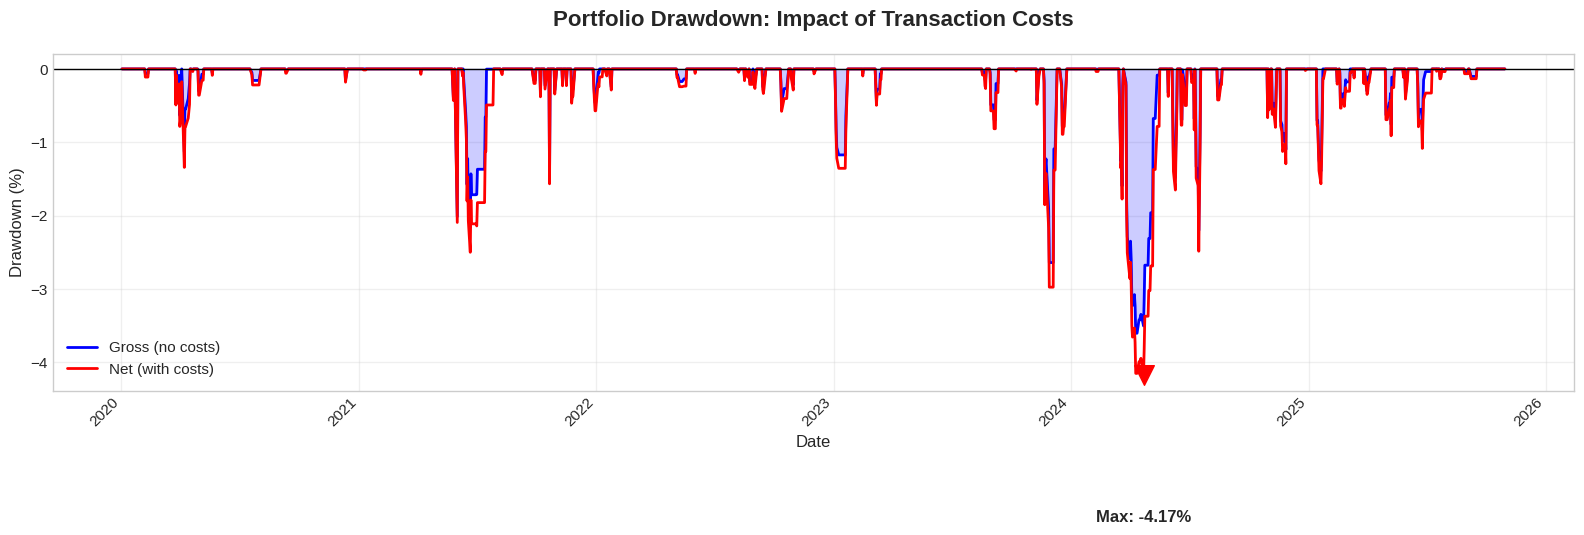

  ✓ Plot 1: Drawdown Comparison


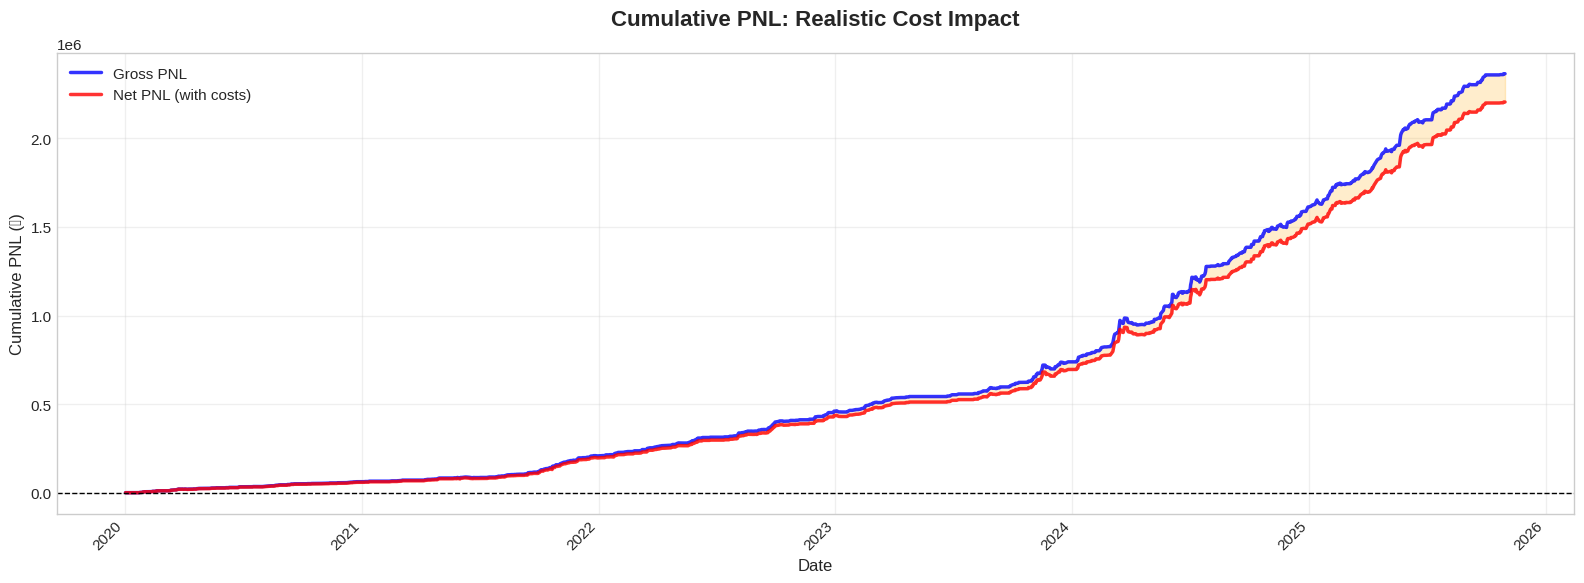

  ✓ Plot 2: Cumulative PNL Comparison


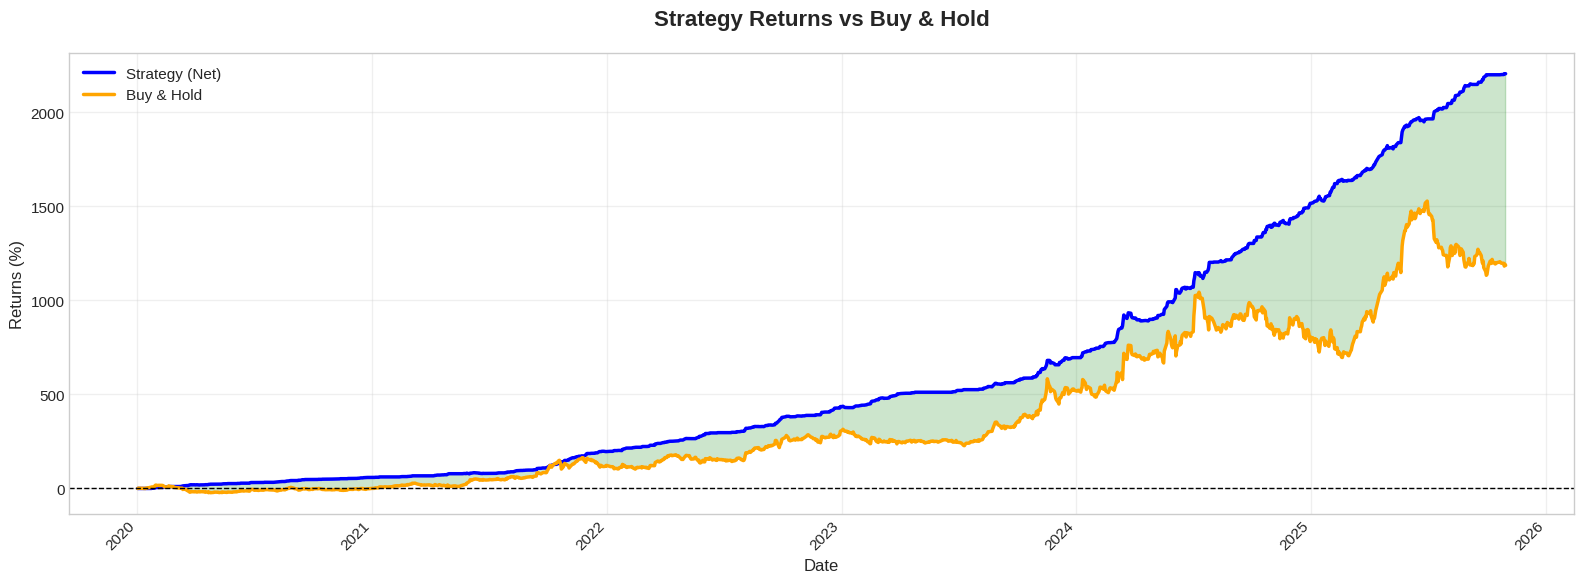

  ✓ Plot 3: Strategy vs Buy & Hold


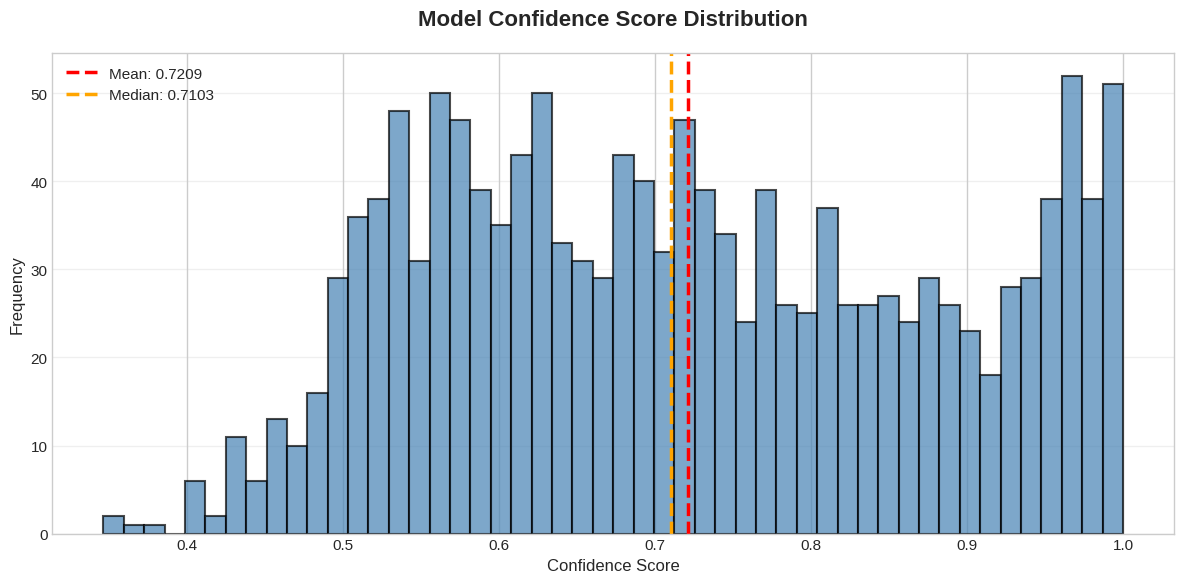

  ✓ Plot 4: Confidence Distribution


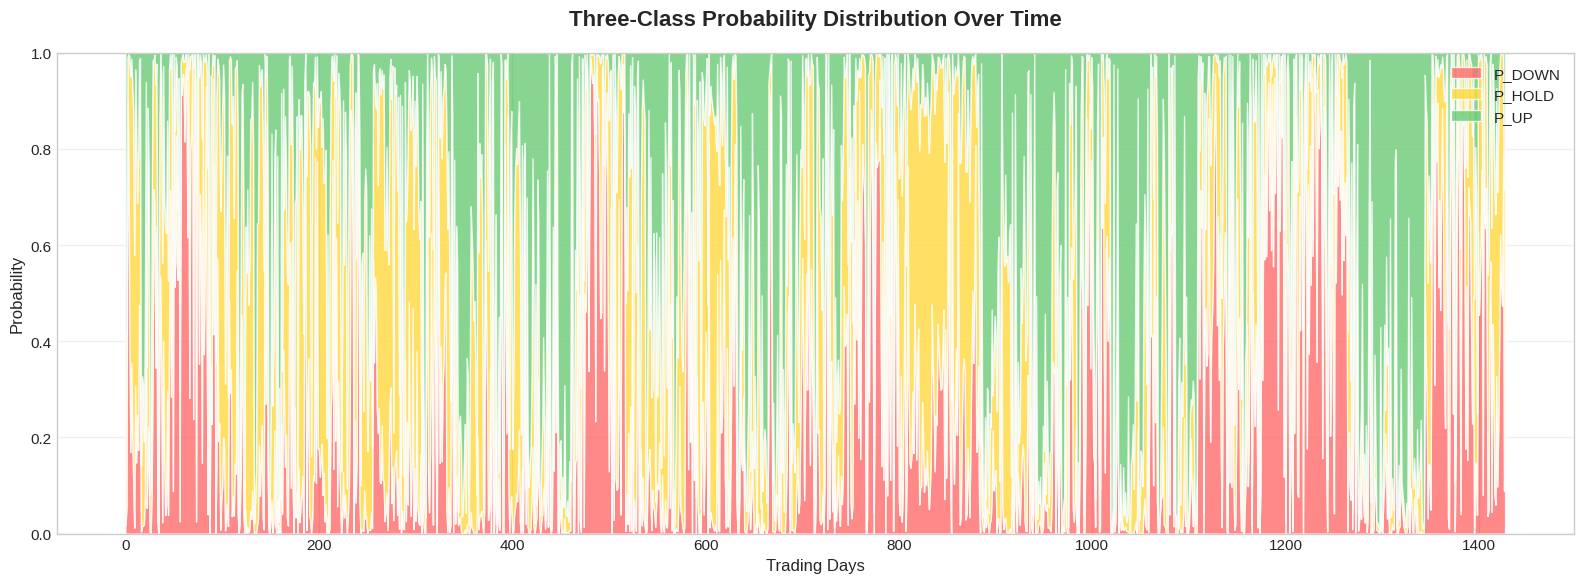

  ✓ Plot 5: Probability Distribution


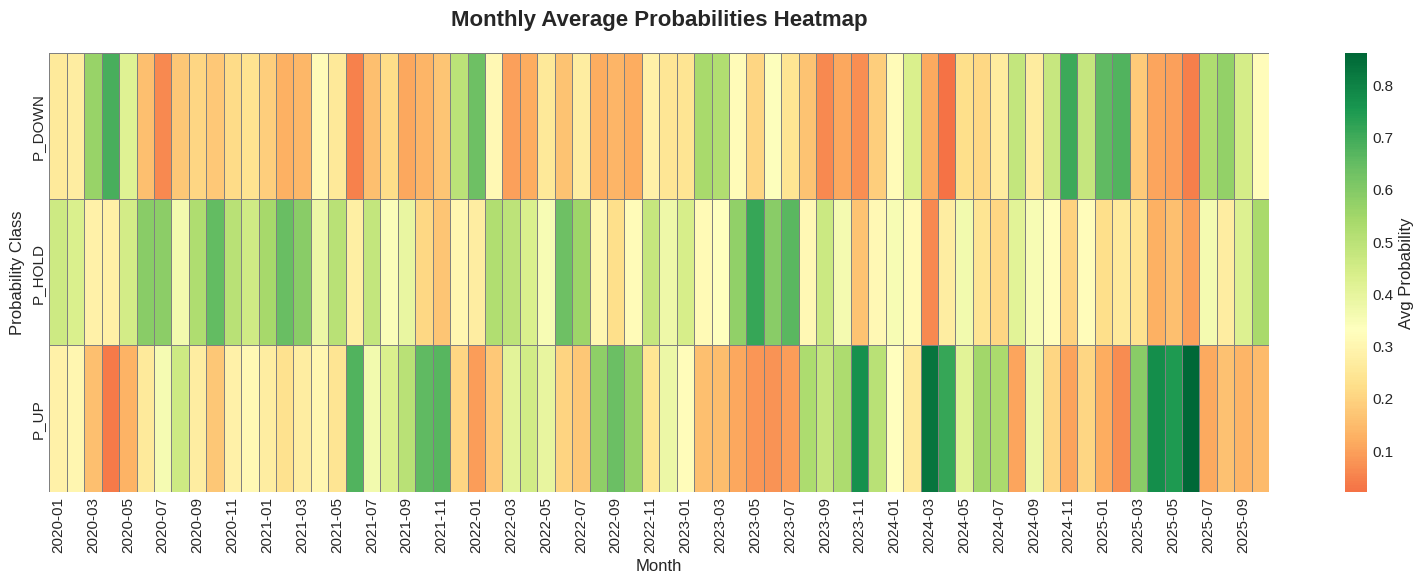

  ✓ Plot 6: Monthly Probability Heatmap


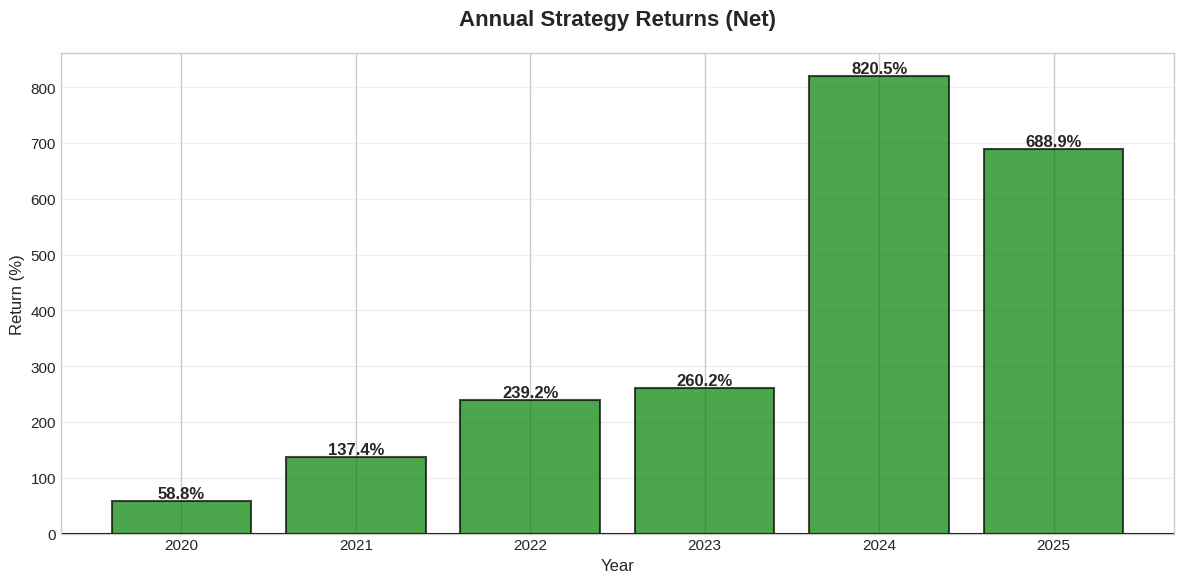

  ✓ Plot 7: Annual Returns


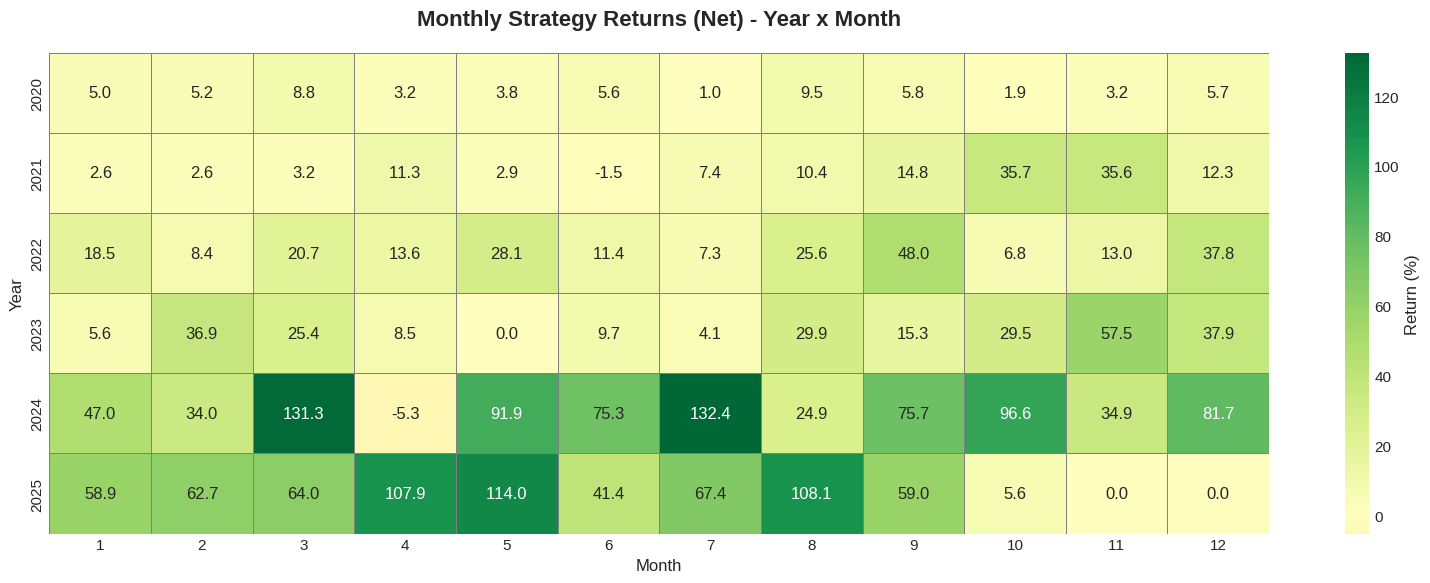

  ✓ Plot 8: Monthly Returns Heatmap


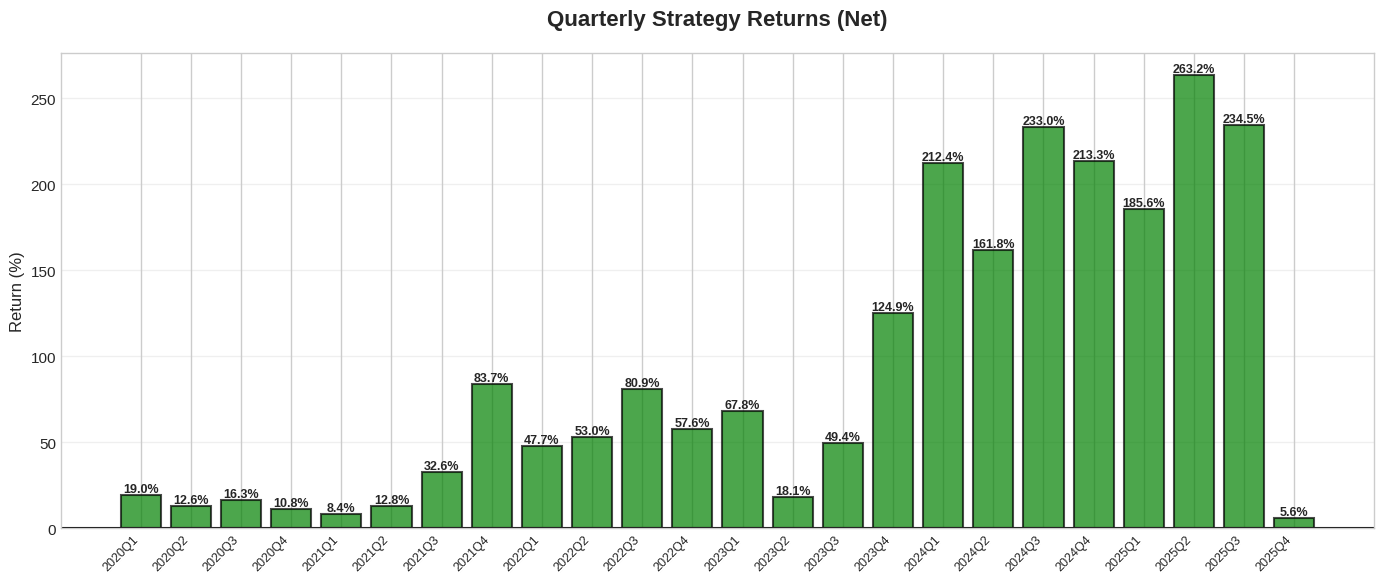

  ✓ Plot 9: Quarterly Returns


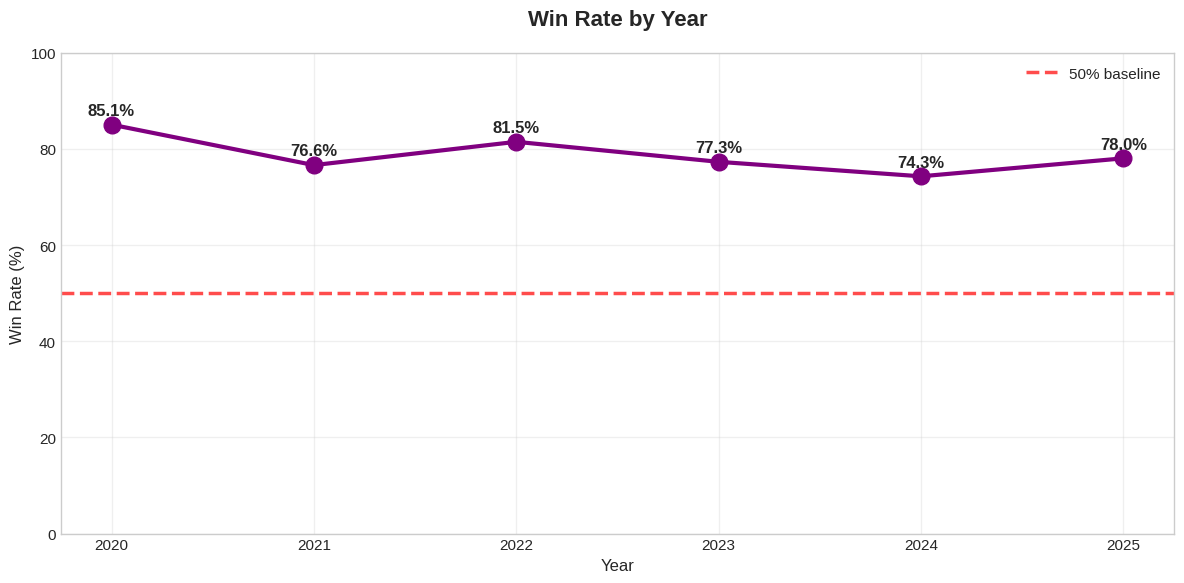

  ✓ Plot 10: Win Rate by Year

ANALYSIS COMPLETE!

✓ Results saved to: unified_backtest_with_model_analysis.csv



In [326]:
# ============================================================================
# UNIFIED BACKTEST WITH MODEL QUALITY ANALYSIS
# File: unified_backtest_with_model_analysis.py
# ============================================================================
# Includes:
# 1. Realistic transaction costs & slippage
# 2. Drawdown & PNL analysis
# 3. Model quality metrics (probability distributions, confidence analysis)
# 4. NO volatility regime or RSI-based plots
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ============================================================================
# TRANSACTION COSTS & SLIPPAGE
# ============================================================================

class TradingCosts:
    BROKERAGE_BUY = 0.0003
    BROKERAGE_SELL = 0.0003
    STT_SELL = 0.00025
    GST_RATE = 0.18
    EXCHANGE_CHARGES = 0.000005
    CLEARING_CHARGES = 0.000005

    @staticmethod
    def calculate_transaction_cost(price, quantity, side='buy'):
        trade_value = price * quantity
        brokerage = trade_value * (TradingCosts.BROKERAGE_BUY if side == 'buy' else TradingCosts.BROKERAGE_SELL)
        gst = brokerage * TradingCosts.GST_RATE
        stt = trade_value * TradingCosts.STT_SELL if side == 'sell' else 0
        exchange_clearing = trade_value * (TradingCosts.EXCHANGE_CHARGES + TradingCosts.CLEARING_CHARGES)
        return brokerage + gst + stt + exchange_clearing

class SlippageModel:
    @staticmethod
    def calculate_slippage(price, volatility_level=50, order_size=1):
        base_slippage = 0.0005
        if volatility_level > 70:
            vol_adjustment = 0.005
        elif volatility_level > 50:
            vol_adjustment = 0.003
        else:
            vol_adjustment = 0.0010
        if order_size > 50:
            size_adjustment = order_size * 0.00001
        else:
            size_adjustment = 0
        return base_slippage + vol_adjustment + size_adjustment

    @staticmethod
    def apply_slippage(price, slippage_pct, side='buy'):
        if side == 'buy':
            return price * (1 + slippage_pct)
        else:
            return price * (1 - slippage_pct)

# ============================================================================
# LOAD & PREPARE DATA
# ============================================================================

print("\n" + "="*70)
print("UNIFIED ENSEMBLE BACKTEST WITH MODEL ANALYSIS")
print("="*70 + "\n")

print("[1] Loading data...")

softmax_df = pd.read_csv('combined_probability_scores_sorted.csv')
xgb_df = pd.read_csv('XGB_Probability_Scores_Sorted.csv')

softmax_df['Date'] = pd.to_datetime(softmax_df['Date'])
xgb_df['Date'] = pd.to_datetime(xgb_df['Date'])

softmax_df = softmax_df.sort_values('Date').reset_index(drop=True)
xgb_df = xgb_df.sort_values('Date').reset_index(drop=True)

# Create ensemble
ensemble_df = pd.DataFrame()
ensemble_df['P_DOWN'] = (softmax_df['P_0'] + xgb_df['P_DOWN']) / 2
ensemble_df['P_HOLD'] = (softmax_df['P_1'] + xgb_df['P_HOLD']) / 2
ensemble_df['P_UP'] = (softmax_df['P_2'] + xgb_df['P_UP']) / 2

def get_signal(row):
    if row['P_UP'] >= row['P_DOWN'] and row['P_UP'] >= row['P_HOLD']:
        return 2, 'UP', row['P_UP']
    elif row['P_DOWN'] >= row['P_HOLD']:
        return 0, 'DOWN', row['P_DOWN']
    else:
        return 1, 'HOLD', row['P_HOLD']

results = ensemble_df.apply(lambda row: get_signal(row), axis=1, result_type='expand')
ensemble_df['Predicted_Numeric'] = results[0]
ensemble_df['Predicted'] = results[1]
ensemble_df['Confidence'] = results[2]
ensemble_df['Date'] = softmax_df['Date'].values
ensemble_df['Close_SOLARINDS.NS'] = softmax_df['Close_SOLARINDS.NS'].values
ensemble_df['RSI'] = softmax_df['RSI'].values if 'RSI' in softmax_df.columns else 50

print(f"  ✓ Data loaded: {len(ensemble_df)} trading days")

# ============================================================================
# BACKTEST WITH REALISTIC COSTS
# ============================================================================

print("\n[2] Running backtest with realistic costs...")

account_capital = 100000
confidence_threshold = 0.60
stop_loss_pct = 0.02
position_size = 40

cumulative_pnl_gross = 0
cumulative_pnl_net = 0
cumulative_costs = 0

results_list = {
    'Date': [],
    'Close': [],
    'Predicted': [],
    'Confidence': [],
    'P_DOWN': [],
    'P_HOLD': [],
    'P_UP': [],
    'Daily_PNL_Gross': [],
    'Transaction_Cost': [],
    'Daily_PNL_Net': [],
    'Cumulative_PNL_Gross': [],
    'Cumulative_PNL_Net': [],
    'Portfolio_Value_Gross': [],
    'Portfolio_Value_Net': [],
}

for i in range(len(ensemble_df)):
    current_confidence = ensemble_df.loc[i, 'Confidence']
    signal_class = ensemble_df.loc[i, 'Predicted_Numeric']

    if current_confidence >= confidence_threshold and signal_class != 1:
        if i == 0:
            prev_close = ensemble_df.loc[i, 'Close_SOLARINDS.NS']
        else:
            prev_close = ensemble_df.loc[i-1, 'Close_SOLARINDS.NS']

        current_close = ensemble_df.loc[i, 'Close_SOLARINDS.NS']
        rsi = ensemble_df.loc[i, 'RSI']
        slippage_pct = SlippageModel.calculate_slippage(prev_close, rsi, position_size)

        if signal_class == 2:  # BUY
            entry_actual = SlippageModel.apply_slippage(prev_close, slippage_pct, side='buy')
            buy_txn = TradingCosts.calculate_transaction_cost(entry_actual, position_size, side='buy')

            exit_slippage_pct = SlippageModel.calculate_slippage(current_close, rsi, position_size)
            exit_actual = SlippageModel.apply_slippage(current_close, exit_slippage_pct, side='sell')
            sell_txn = TradingCosts.calculate_transaction_cost(exit_actual, position_size, side='sell')

            total_txn_cost = buy_txn + sell_txn
            daily_pnl_gross = (exit_actual - entry_actual) * position_size

        else:  # SHORT
            entry_actual = SlippageModel.apply_slippage(prev_close, slippage_pct, side='sell')
            sell_txn = TradingCosts.calculate_transaction_cost(entry_actual, position_size, side='sell')

            exit_slippage_pct = SlippageModel.calculate_slippage(current_close, rsi, position_size)
            exit_actual = SlippageModel.apply_slippage(current_close, exit_slippage_pct, side='buy')
            buy_txn = TradingCosts.calculate_transaction_cost(exit_actual, position_size, side='buy')

            total_txn_cost = sell_txn + buy_txn
            daily_pnl_gross = (entry_actual - exit_actual) * position_size

    else:
        daily_pnl_gross = 0
        total_txn_cost = 0

    daily_pnl_net = daily_pnl_gross - total_txn_cost
    cumulative_pnl_gross += daily_pnl_gross
    cumulative_pnl_net += daily_pnl_net
    cumulative_costs += total_txn_cost

    results_list['Date'].append(ensemble_df.loc[i, 'Date'])
    results_list['Close'].append(ensemble_df.loc[i, 'Close_SOLARINDS.NS'])
    results_list['Predicted'].append(ensemble_df.loc[i, 'Predicted'])
    results_list['Confidence'].append(current_confidence)
    results_list['P_DOWN'].append(ensemble_df.loc[i, 'P_DOWN'])
    results_list['P_HOLD'].append(ensemble_df.loc[i, 'P_HOLD'])
    results_list['P_UP'].append(ensemble_df.loc[i, 'P_UP'])
    results_list['Daily_PNL_Gross'].append(daily_pnl_gross)
    results_list['Transaction_Cost'].append(total_txn_cost)
    results_list['Daily_PNL_Net'].append(daily_pnl_net)
    results_list['Cumulative_PNL_Gross'].append(cumulative_pnl_gross)
    results_list['Cumulative_PNL_Net'].append(cumulative_pnl_net)
    results_list['Portfolio_Value_Gross'].append(account_capital + cumulative_pnl_gross)
    results_list['Portfolio_Value_Net'].append(account_capital + cumulative_pnl_net)

results_df = pd.DataFrame(results_list)

# Add temporal columns
results_df['Year'] = results_df['Date'].dt.year
results_df['Month'] = results_df['Date'].dt.month
results_df['Quarter'] = results_df['Date'].dt.quarter
results_df['YearMonth'] = results_df['Date'].dt.to_period('M')

print(f"  ✓ Backtest complete")
print(f"  ✓ Total trades: {len(results_df[results_df['Daily_PNL_Net'] != 0])}")

# ============================================================================
# PERFORMANCE METRICS
# ============================================================================

# NET metrics (with costs)
portfolio_net = results_df['Portfolio_Value_Net'].values
running_max_net = np.maximum.accumulate(portfolio_net)
drawdown_net = ((portfolio_net - running_max_net) / running_max_net) * 100
max_dd_net = drawdown_net.min()

# GROSS metrics (without costs)
portfolio_gross = results_df['Portfolio_Value_Gross'].values
running_max_gross = np.maximum.accumulate(portfolio_gross)
drawdown_gross = ((portfolio_gross - running_max_gross) / running_max_gross) * 100
max_dd_gross = drawdown_gross.min()

# Statistics
profitable = len(results_df[results_df['Daily_PNL_Net'] > 0])
total_trades = len(results_df[results_df['Daily_PNL_Net'] != 0])
win_rate = (profitable / total_trades * 100) if total_trades > 0 else 0

avg_win = results_df[results_df['Daily_PNL_Net'] > 0]['Daily_PNL_Net'].mean()
avg_loss = results_df[results_df['Daily_PNL_Net'] < 0]['Daily_PNL_Net'].mean()

final_pnl_net = results_df['Cumulative_PNL_Net'].iloc[-1]
final_pnl_gross = results_df['Cumulative_PNL_Gross'].iloc[-1]
strat_return_net = (final_pnl_net / account_capital) * 100
strat_return_gross = (final_pnl_gross / account_capital) * 100

initial_price = ensemble_df.loc[0, 'Close_SOLARINDS.NS']
final_price = ensemble_df.iloc[-1]['Close_SOLARINDS.NS']
bh_return = (final_price / initial_price - 1) * 100

sharpe_net = (results_df['Daily_PNL_Net'].mean() / results_df['Daily_PNL_Net'].std()) * np.sqrt(252) if results_df['Daily_PNL_Net'].std() != 0 else 0

# Print summary
print("\n" + "="*70)
print("PERFORMANCE SUMMARY (WITH REALISTIC COSTS)")
print("="*70)

print(f"\nNET RETURNS (After Transaction Costs):")
print(f"  Net PNL: ₹{final_pnl_net:,.0f}")
print(f"  Strategy Return: {strat_return_net:.2f}%")
print(f"  Buy & Hold Return: {bh_return:.2f}%")
print(f"  Outperformance: {strat_return_net - bh_return:+.2f}%")

print(f"\nGROSS RETURNS (Before Costs):")
print(f"  Gross PNL: ₹{final_pnl_gross:,.0f}")
print(f"  Strategy Return: {strat_return_gross:.2f}%")

print(f"\nRISK METRICS:")
print(f"  Max Drawdown (Gross): {max_dd_gross:.2f}%")
print(f"  Max Drawdown (Net): {max_dd_net:.2f}%")
print(f"  Sharpe Ratio: {sharpe_net:.2f}")

print(f"\nTRADE QUALITY:")
print(f"  Total Trades: {total_trades}")
print(f"  Win Rate: {win_rate:.2f}%")
print(f"  Avg Winning Trade: ₹{avg_win:,.0f}")
print(f"  Avg Losing Trade: ₹{avg_loss:,.0f}")
print(f"  Profit Factor: {avg_win / abs(avg_loss):.2f}x")

print(f"\nCOST ANALYSIS:")
print(f"  Total Transaction Costs: ₹{cumulative_costs:,.0f}")
print(f"  Cost Impact: {(cumulative_costs / final_pnl_gross * 100):.2f}% of gross PNL")

print("\n" + "="*70 + "\n")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("[3] Generating visualizations...\n")

# PLOT 1: Drawdown Comparison (Gross vs Net)
fig1, ax1 = plt.subplots(figsize=(16, 6))

ax1.fill_between(results_df['Date'], drawdown_gross, 0, alpha=0.2, color='blue')
ax1.plot(results_df['Date'], drawdown_gross, linewidth=2, color='blue', label='Gross (no costs)')
ax1.plot(results_df['Date'], drawdown_net, linewidth=2, color='red', label='Net (with costs)')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Annotate max drawdowns
ax1.scatter(results_df.loc[np.argmin(drawdown_net), 'Date'], max_dd_net,
           color='red', s=200, zorder=5, marker='v')
ax1.text(results_df.loc[np.argmin(drawdown_net), 'Date'], max_dd_net - 2,
        f'Max: {max_dd_net:.2f}%', ha='center', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax1.set_title('Portfolio Drawdown: Impact of Transaction Costs', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Drawdown (%)', fontsize=12)
ax1.legend(fontsize=11, loc='lower left')
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("  ✓ Plot 1: Drawdown Comparison")

# PLOT 2: Cumulative PNL (Gross vs Net)
fig2, ax2 = plt.subplots(figsize=(16, 6))

ax2.plot(results_df['Date'], results_df['Cumulative_PNL_Gross'], linewidth=2.5, color='blue', label='Gross PNL', alpha=0.8)
ax2.plot(results_df['Date'], results_df['Cumulative_PNL_Net'], linewidth=2.5, color='red', label='Net PNL (with costs)', alpha=0.8)
ax2.fill_between(results_df['Date'], results_df['Cumulative_PNL_Gross'], results_df['Cumulative_PNL_Net'],
                 alpha=0.2, color='orange')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)

ax2.set_title('Cumulative PNL: Realistic Cost Impact', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Cumulative PNL (₹)', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("  ✓ Plot 2: Cumulative PNL Comparison")

# PLOT 3: Strategy vs Buy & Hold
fig3, ax3 = plt.subplots(figsize=(16, 6))

initial_capital = account_capital
buy_hold_values = (ensemble_df['Close_SOLARINDS.NS'] / initial_price) * initial_capital
buy_hold_returns = ((buy_hold_values / initial_capital) - 1) * 100
strategy_returns_net = ((results_df['Portfolio_Value_Net'] / initial_capital) - 1) * 100

ax3.plot(results_df['Date'], strategy_returns_net, linewidth=2.5, label='Strategy (Net)', color='blue')
ax3.plot(results_df['Date'], buy_hold_returns, linewidth=2.5, label='Buy & Hold', color='orange')

ax3.fill_between(results_df['Date'], strategy_returns_net, buy_hold_returns,
                where=(strategy_returns_net >= buy_hold_returns), alpha=0.2, color='green')
ax3.fill_between(results_df['Date'], strategy_returns_net, buy_hold_returns,
                where=(strategy_returns_net < buy_hold_returns), alpha=0.2, color='red')

ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_title('Strategy Returns vs Buy & Hold', fontsize=16, fontweight='bold', pad=20)
ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('Returns (%)', fontsize=12)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax3.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("  ✓ Plot 3: Strategy vs Buy & Hold")

# PLOT 4: Confidence Distribution
fig4, ax4 = plt.subplots(figsize=(12, 6))

ax4.hist(ensemble_df['Confidence'], bins=50, color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.axvline(ensemble_df['Confidence'].mean(), color='red', linestyle='--', linewidth=2.5,
           label=f'Mean: {ensemble_df["Confidence"].mean():.4f}')
ax4.axvline(ensemble_df['Confidence'].median(), color='orange', linestyle='--', linewidth=2.5,
           label=f'Median: {ensemble_df["Confidence"].median():.4f}')

ax4.set_title('Model Confidence Score Distribution', fontsize=16, fontweight='bold', pad=20)
ax4.set_xlabel('Confidence Score', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.legend(fontsize=11, framealpha=0.95)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("  ✓ Plot 4: Confidence Distribution")

# PLOT 5: Probability Distribution (Stacked Area)
fig5, ax5 = plt.subplots(figsize=(16, 6))

ax5.stackplot(np.arange(len(ensemble_df)),
             ensemble_df['P_DOWN'],
             ensemble_df['P_HOLD'],
             ensemble_df['P_UP'],
             labels=['P_DOWN', 'P_HOLD', 'P_UP'],
             colors=['#FF6B6B', '#FFD93D', '#6BCB77'],
             alpha=0.8)

ax5.set_title('Three-Class Probability Distribution Over Time', fontsize=16, fontweight='bold', pad=20)
ax5.set_ylabel('Probability', fontsize=12)
ax5.set_xlabel('Trading Days', fontsize=12)
ax5.legend(loc='upper right', fontsize=11, framealpha=0.95)
ax5.set_ylim([0, 1])
ax5.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("  ✓ Plot 5: Probability Distribution")

# PLOT 6: Monthly Average Probabilities Heatmap
fig6, ax6 = plt.subplots(figsize=(16, 6))

monthly_data = results_df.groupby('YearMonth')[['P_DOWN', 'P_HOLD', 'P_UP']].mean()
heatmap_data = monthly_data.T

sns.heatmap(heatmap_data, cmap='RdYlGn', center=0.33, ax=ax6,
           cbar_kws={'label': 'Avg Probability'}, linewidths=0.5, linecolor='gray')

ax6.set_title('Monthly Average Probabilities Heatmap', fontsize=16, fontweight='bold', pad=20)
ax6.set_xlabel('Month', fontsize=12)
ax6.set_ylabel('Probability Class', fontsize=12)

plt.tight_layout()
plt.show()

print("  ✓ Plot 6: Monthly Probability Heatmap")

# PLOT 7: Annual Returns
fig7, ax7 = plt.subplots(figsize=(12, 6))

annual_returns = results_df.groupby('Year')['Daily_PNL_Net'].sum() / account_capital * 100

colors = ['green' if x > 0 else 'red' for x in annual_returns]
bars = ax7.bar(annual_returns.index.astype(str), annual_returns.values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

for bar in bars:
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

ax7.set_title('Annual Strategy Returns (Net)', fontsize=16, fontweight='bold', pad=20)
ax7.set_ylabel('Return (%)', fontsize=12)
ax7.set_xlabel('Year', fontsize=12)
ax7.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax7.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("  ✓ Plot 7: Annual Returns")

# PLOT 8: Monthly Returns Heatmap
fig8, ax8 = plt.subplots(figsize=(16, 6))

monthly_returns_pnl = results_df.groupby(['Year', 'Month'])['Daily_PNL_Net'].sum().unstack(fill_value=0)
monthly_returns_pct = (monthly_returns_pnl / account_capital * 100)

sns.heatmap(monthly_returns_pct, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax8,
           cbar_kws={'label': 'Return (%)'}, linewidths=0.5, linecolor='gray')

ax8.set_title('Monthly Strategy Returns (Net) - Year x Month', fontsize=16, fontweight='bold', pad=20)
ax8.set_xlabel('Month', fontsize=12)
ax8.set_ylabel('Year', fontsize=12)

plt.tight_layout()
plt.show()

print("  ✓ Plot 8: Monthly Returns Heatmap")

# PLOT 9: Quarterly Returns
fig9, ax9 = plt.subplots(figsize=(14, 6))

quarterly_returns = results_df.groupby(['Year', 'Quarter'])['Daily_PNL_Net'].sum()
quarters = [f"{y}Q{q}" for y, q in quarterly_returns.index]
quarterly_returns_pct = (quarterly_returns / account_capital * 100)

colors_q = ['green' if x > 0 else 'red' for x in quarterly_returns_pct]
bars = ax9.bar(range(len(quarterly_returns_pct)), quarterly_returns_pct.values, color=colors_q, alpha=0.7, edgecolor='black', linewidth=1.5)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax9.text(i, height, f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=9, fontweight='bold')

ax9.set_title('Quarterly Strategy Returns (Net)', fontsize=16, fontweight='bold', pad=20)
ax9.set_ylabel('Return (%)', fontsize=12)
ax9.set_xticks(range(len(quarters)))
ax9.set_xticklabels(quarters, rotation=45, ha='right', fontsize=9)
ax9.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax9.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("  ✓ Plot 9: Quarterly Returns")

# PLOT 10: Win Rate by Year
fig10, ax10 = plt.subplots(figsize=(12, 6))

winning_trades_year = results_df[results_df['Daily_PNL_Net'] > 0].groupby('Year').size()
total_trades_year = results_df[results_df['Daily_PNL_Net'] != 0].groupby('Year').size()
win_rate_year = (winning_trades_year / total_trades_year * 100).fillna(0)

ax10.plot(win_rate_year.index, win_rate_year.values, marker='o', linewidth=3, markersize=12, color='purple')
ax10.axhline(y=50, color='red', linestyle='--', linewidth=2.5, label='50% baseline', alpha=0.7)

ax10.set_title('Win Rate by Year', fontsize=16, fontweight='bold', pad=20)
ax10.set_ylabel('Win Rate (%)', fontsize=12)
ax10.set_xlabel('Year', fontsize=12)
ax10.set_ylim([0, 100])
ax10.legend(fontsize=11)
ax10.grid(True, alpha=0.3)

for x, y in zip(win_rate_year.index, win_rate_year.values):
    ax10.text(x, y + 2, f'{y:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("  ✓ Plot 10: Win Rate by Year")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)

# Export results
results_df.to_csv('unified_backtest_with_model_analysis.csv', index=False)
print("\n✓ Results saved to: unified_backtest_with_model_analysis.csv\n")
